In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

try:
    import torch  # type: ignore[import]
    import torch.nn as nn  # type: ignore[import]
    from torch.utils.data import TensorDataset, DataLoader, random_split  # type: ignore[import]
except ImportError as exc:
    raise ImportError(
        "PyTorch is required for this notebook. Please install torch."
    ) from exc

try:
    from sklearn.preprocessing import MinMaxScaler, StandardScaler  # type: ignore[import]
except ImportError as exc:
    raise ImportError(
        "scikit-learn is required for this notebook. Please install scikit-learn."
    ) from exc

torch.manual_seed(42)

import sys
root_dir = os.path.abspath("..")
if root_dir not in sys.path:
    sys.path.append(root_dir)

from src.config import (
    CMAPSS_DATASETS,
    MAX_RUL,
    SEQUENCE_LENGTH,
    HIDDEN_SIZE,
    NUM_LAYERS,
    OUTPUT_SIZE,
    LEARNING_RATE,
    NUM_EPOCHS,
    GLOBAL_FEATURE_COLS,
    GLOBAL_DROP_COLS 
)

from src.data_loading import load_cmapps_subset
from src.additional_features import (
    create_physical_features,
    create_all_features,
    FeatureConfig,
    TemporalFeatureConfig,
    get_feature_columns,
    add_temporal_window_features,
)
from src.feature_config import FeatureGroupsConfig, TemporalWindowConfig
from src.feature_safety import remove_rul_leakage
from src.eol_full_lstm import (
    build_full_eol_sequences_from_df,
    create_full_dataloaders,
    EOLFullLSTM,
    train_eol_full_lstm,
    evaluate_eol_full_lstm,
    evaluate_on_test_data,
)


In [2]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


# Full-Trajectory LSTM für EOL-Prediction (FD001-FD004 - Separate Training)

Dieses Notebook trainiert für jedes CMAPSS-Dataset (FD001, FD002, FD003, FD004) **separat** ein LSTM-Modell für EOL-Prediction.

**Features:**
- Sliding-Window über alle Zyklen jeder Engine
- RUL wird auf max_rul=125 gecappt (NASA-Style)
- Engine-basierter Split (keine Data Leakage)
- NASA PHM08 Score Evaluation
- **Vergleichstabelle** aller Metriken am Ende
- **Multi-Scale Temporal Features** mit konfigurierbarem Feature-Engineering


In [3]:
# ===================================================================
# Konfiguration: Datasets und Hyperparameter
# ===================================================================
FD_DATASETS = ["FD001", "FD002", "FD003", "FD004"] #, "FD002", "FD003", "FD004"

# Physics Feature Config Varianten für Ablation
from src.config import PhysicsFeatureConfig

PHYSICS_CONFIG_VARIANTS = {
    "baseline": PhysicsFeatureConfig(
        use_core=True,
        use_extended=False,
        use_residuals=False,
        use_temporal_on_physics=False,
    ),
    "extended": PhysicsFeatureConfig(
        use_core=True,
        use_extended=True,
        use_residuals=False,
        use_temporal_on_physics=False,
    ),
    "residuals": PhysicsFeatureConfig(
        use_core=True,
        use_extended=False,
        use_residuals=True,
        use_temporal_on_physics=False,
    ),
    "temporal": PhysicsFeatureConfig(
        use_core=True,
        use_extended=False,
        use_residuals=False,
        use_temporal_on_physics=True,
    ),
    "all": PhysicsFeatureConfig(
        use_core=True,
        use_extended=True,
        use_residuals=True,
        use_temporal_on_physics=True,
    ),
}

print("Physics Config Variants:")
for name, config in PHYSICS_CONFIG_VARIANTS.items():
    print(f"  {name}: core={config.use_core}, extended={config.use_extended}, "
          f"residuals={config.use_residuals}, temporal={config.use_temporal_on_physics}")

# Training-Parameter (gleich für alle Datasets)
TRAINING_CONFIG = {
    "past_len": 30,
    "max_rul": 125,
    "batch_size": 32,  # REDUZIERT auf 32 für Colab (weniger RAM bei vielen Features)
    "engine_train_ratio": 0.8,
    "num_epochs": 80,
    "lr": 1e-4,
    "weight_decay": 1e-4,
    "patience": 8,
    "hidden_dim": 64,
    "num_layers": 2,
    "dropout": 0.1,
    "bidirectional": False,
}

# Für Colab: Weitere RAM-Optimierungen
# Wenn immer noch zu wenig RAM, reduziere weiter:
# "batch_size": 16,  # Noch kleiner (Minimum)
# "hidden_dim": 32,  # Kleinere Hidden-Dimension
# "num_layers": 1,   # Weniger LSTM-Layers

print("=" * 60)
print("Training Configuration")
print("=" * 60)
for key, value in TRAINING_CONFIG.items():
    print(f"  {key}: {value}")
print("=" * 60)

# ===================================================================
# Feature Engineering Configuration
# ===================================================================
# Vollausbau: Physik + Temporal Features
FEATURE_CONFIG = FeatureConfig(
    add_physical_core=True,
    add_temporal_features=True,
    temporal=TemporalFeatureConfig(
        # None → automatisch aus df bestimmt
        base_cols=None,
        short_windows=(5, 10),
        long_windows=(30,),
        add_rolling_mean=True,
        add_rolling_std=False,
        add_trend=True,
        add_delta=True,
        delta_lags=(5, 10),
    ),
)

print("\n" + "=" * 60)
print("Feature Engineering Configuration")
print("=" * 60)
print(f"  Physical Core Features: {FEATURE_CONFIG.add_physical_core}")
print(f"  Temporal Features: {FEATURE_CONFIG.add_temporal_features}")
if FEATURE_CONFIG.add_temporal_features:
    temp_cfg = FEATURE_CONFIG.temporal
    print(f"    Base columns: {temp_cfg.base_cols if temp_cfg.base_cols else 'Auto-inferred'}")
    print(f"    Short windows: {temp_cfg.short_windows}")
    print(f"    Long windows: {temp_cfg.long_windows}")
    print(f"    Rolling mean: {temp_cfg.add_rolling_mean}")
    print(f"    Rolling std: {temp_cfg.add_rolling_std}")
    print(f"    Trend: {temp_cfg.add_trend}")
    print(f"    Delta: {temp_cfg.add_delta}")
    print(f"    Delta lags: {temp_cfg.delta_lags}")
print("=" * 60)

# ===================================================================
# SANITY CHECK: Temporal Features - No Future Information
# ===================================================================
print("\n" + "=" * 60)
print("SANITY CHECK: Temporal Features Implementation")
print("=" * 60)
print("Checking for future information leakage...")

# Check the implementation in additional_features.py
import inspect
from src.additional_features import add_temporal_features

# Get source code of add_temporal_features
source = inspect.getsource(add_temporal_features)

# Check for suspicious patterns
checks = {
    "center=True": "center=True" in source,
    "shift(-": "shift(-" in source,
    "shift(-k)": "shift(-k)" in source or "shift(-" in source,
    "future": "future" in source.lower() and "no future" not in source.lower(),
}

print("\n  Temporal Feature Implementation Checks:")
all_ok = True
for check_name, found in checks.items():
    if found:
        print(f"  ⚠️  WARNING: Found '{check_name}' in temporal features code!")
        all_ok = False
    else:
        print(f"  ✓ No '{check_name}' found")

if all_ok:
    print("\n  ✓ Temporal features use only past information (no future leakage)")
else:
    print("\n  ⚠️  WARNING: Potential future information leakage detected!")

print("=" * 60)


Physics Config Variants:
  baseline: core=True, extended=False, residuals=False, temporal=False
  extended: core=True, extended=True, residuals=False, temporal=False
  residuals: core=True, extended=False, residuals=True, temporal=False
  temporal: core=True, extended=False, residuals=False, temporal=True
  all: core=True, extended=True, residuals=True, temporal=True
Training Configuration
  past_len: 30
  max_rul: 125
  batch_size: 32
  engine_train_ratio: 0.8
  num_epochs: 80
  lr: 0.0001
  weight_decay: 0.0001
  patience: 8
  hidden_dim: 64
  num_layers: 2
  dropout: 0.1
  bidirectional: False

Feature Engineering Configuration
  Physical Core Features: True
  Temporal Features: True
    Base columns: Auto-inferred
    Short windows: (5, 10)
    Long windows: (30,)
    Rolling mean: True
    Rolling std: False
    Trend: True
    Delta: True
    Delta lags: (5, 10)

SANITY CHECK: Temporal Features Implementation
Checking for future information leakage...

  Temporal Feature Implemen

In [4]:
# ===================================================================
# Dictionary zum Speichern der Ergebnisse für jeden Dataset
# ===================================================================
results_dict = {}

for fd_id in FD_DATASETS:
    results_dict[fd_id] = {
        "model": None,
        "history": None,
        "metrics": None,
        "scaler": None,
        "num_engines": None,
        "num_samples": None,
    }

# Zusätzlich: Kombiniertes Dataset (FD001-FD004)
results_dict["FD001_FD004"] = {
    "model": None,
    "history": None,
    "metrics": None,
    "scaler": None,
    "num_engines": None,
    "num_samples": None,
}


In [5]:
# ===================================================================
# Training-Loop: Physics Feature Ablation Study
# Jedes Dataset × Jede Physics-Config-Variante
# ===================================================================

# Results dictionary für alle Runs
physics_results = {}  # {fd_id: {variant_name: {model, history, metrics, ...}}}

for fd_id in FD_DATASETS:
    physics_results[fd_id] = {}
    
    # Load data once per dataset (shared across variants)
    print("\n" + "=" * 80)
    print(f"Loading data for {fd_id}")
    print("=" * 80)
    
    df_train_base, df_test_base, y_test_true = load_cmapps_subset(
        fd_id,
        max_rul=None,
        clip_train=False,
        clip_test=True,
    )
    
    # FD_ID als numerisches Feature
    fd_id_map = {"FD001": 0, "FD002": 1, "FD003": 2, "FD004": 3}
    df_train_base["FD_ID"] = fd_id_map[fd_id]
    
    # Verifikation
    print(f"  Train: {len(df_train_base)} rows, {df_train_base['UnitNumber'].nunique()} engines")
    print(f"  Test: {len(df_test_base)} rows, {df_test_base['UnitNumber'].nunique()} engines")
    print(f"  Test RUL: {len(y_test_true)} values (one per engine)")
    assert len(y_test_true) == df_test_base['UnitNumber'].nunique(), \
        f"Mismatch: {len(y_test_true)} RUL values but {df_test_base['UnitNumber'].nunique()} test engines"
    print(f"  ✓ Train/Test data loaded correctly")
    
    # Train each physics variant
    for variant_name, physics_config in PHYSICS_CONFIG_VARIANTS.items():
        print("\n" + "=" * 80)
        print(f"Processing {fd_id} - Physics Variant: {variant_name}")
        print("=" * 80)
        
        # Initialize results for this variant
        physics_results[fd_id][variant_name] = {
            "model": None,
            "history": None,
            "metrics": None,
            "metrics_test": None,
            "scaler": None,
            "feature_cols": None,
            "physics_config": physics_config,
        }
        
        # -------------------------------------------------------------------
        # 1b. Feature Engineering mit Physics Config
        # -------------------------------------------------------------------
        print(f"\n[{fd_id}] [{variant_name}] Step 1b: Feature Engineering...")
        print(f"  Physics Config: core={physics_config.use_core}, "
              f"extended={physics_config.use_extended}, "
              f"residuals={physics_config.use_residuals}, "
              f"temporal={physics_config.use_temporal_on_physics}")
        
        # Create a copy for this variant
        df_train_variant = df_train_base.copy()
        df_test_variant = df_test_base.copy()
        
        # Apply physics features with specific config
        df_train_variant = create_physical_features(
            df_train_variant,
            physics_config=physics_config,
            unit_col="UnitNumber",
            cycle_col="TimeInCycles",
        )
        
        # Apply same physics to test data
        df_test_variant = create_physical_features(
            df_test_variant,
            physics_config=physics_config,
            unit_col="UnitNumber",
            cycle_col="TimeInCycles",
        )
        
        # Apply temporal features (if enabled in FEATURE_CONFIG)
        num_cols_before = len(df_train_variant.columns)
        df_train_variant = create_all_features(
            df_train_variant,
            unit_col="UnitNumber",
            cycle_col="TimeInCycles",
            config=FEATURE_CONFIG,
            inplace=False,
        )
        
        # Apply temporal features to test data
        df_test_variant = create_all_features(
            df_test_variant,
            unit_col="UnitNumber",
            cycle_col="TimeInCycles",
            config=FEATURE_CONFIG,
            inplace=False,
        )
        
        num_cols_after = len(df_train_variant.columns)
        num_new_features = num_cols_after - num_cols_before
        print(f"  Features: {num_cols_before} → {num_cols_after} (+{num_new_features} new features)")
        
        # -------------------------------------------------------------------
        # 1c. NaN-Validierung
        # -------------------------------------------------------------------
        nan_count = df_train_variant.isna().sum().sum()
        if nan_count > 0:
            nan_cols = df_train_variant.columns[df_train_variant.isna().any()].tolist()
            print(f"\n  ⚠️  WARNING: Found {nan_count} NaN values in {len(nan_cols)} columns!")
            print(f"     Filling NaN with 0...")
            df_train_variant = df_train_variant.fillna(0)
            df_test_variant = df_test_variant.fillna(0)
            print(f"     ✓ NaN values handled.")
        else:
            print(f"  ✓ No NaN values found in features.")
        
        # -------------------------------------------------------------------
        # 2. Feature-Liste definieren
        # -------------------------------------------------------------------
        print(f"\n[{fd_id}] [{variant_name}] Step 2: Defining features...")
        
        # SANITY CHECK 1: Prüfe auf RUL-Leakage
        rul_related_cols = [col for col in df_train_variant.columns if "RUL" in col.upper()]
        if len(rul_related_cols) > 0:
            print(f"  ⚠️  WARNING: Found RUL-related columns: {rul_related_cols}")
            print(f"  ⚠️  These will be EXCLUDED from features!")
        
        # Exclude non-feature columns
        exclude_cols = {"UnitNumber", "TimeInCycles", "MaxTime", "FD_ID"}
        exclude_cols.update(rul_related_cols)
        
        # Get all numeric columns except excluded ones
        numeric_cols = [
            col
            for col in df_train_variant.columns
            if col not in exclude_cols and pd.api.types.is_numeric_dtype(df_train_variant[col])
        ]
        feature_cols = numeric_cols
        
        # SANITY CHECK 2: Finale Prüfung der feature_cols
        rul_in_features = [c for c in feature_cols if "RUL" in c.upper()]
        if len(rul_in_features) > 0:
            print(f"  ⚠️  CRITICAL ERROR: RUL found in feature_cols: {rul_in_features}")
            print(f"  ⚠️  Removing RUL from features!")
            feature_cols = [c for c in feature_cols if c not in rul_in_features]
        else:
            print(f"  ✓ No RUL found in final feature_cols")
        
        print(f"  Using {len(feature_cols)} features")
        physics_results[fd_id][variant_name]["feature_cols"] = feature_cols
        
        # -------------------------------------------------------------------
        # 3. Full-Trajectory Sequenzen bauen
        # -------------------------------------------------------------------
        print(f"\n[{fd_id}] [{variant_name}] Step 3: Building sequences...")
        X_full, y_full, unit_ids_full = build_full_eol_sequences_from_df(
            df=df_train_variant,
            feature_cols=feature_cols,
            past_len=TRAINING_CONFIG["past_len"],
            max_rul=TRAINING_CONFIG["max_rul"],
            unit_col="UnitNumber",
            cycle_col="TimeInCycles",
            rul_col="RUL",
        )
        print(f"  Built: {X_full.shape[0]} sequences")
        
        # -------------------------------------------------------------------
        # 4. Dataloaders erstellen (Engine-basierter Split)
        # -------------------------------------------------------------------
        print(f"\n[{fd_id}] [{variant_name}] Step 4: Creating dataloaders...")
        train_loader, val_loader, scaler, train_unit_ids, val_unit_ids = create_full_dataloaders(
            X=X_full,
            y=y_full,
            unit_ids=unit_ids_full,
            batch_size=TRAINING_CONFIG["batch_size"],
            engine_train_ratio=TRAINING_CONFIG["engine_train_ratio"],
            shuffle_engines=True,
            random_seed=42,
        )
        physics_results[fd_id][variant_name]["scaler"] = scaler
        
        # -------------------------------------------------------------------
        # 5. Modell initialisieren
        # -------------------------------------------------------------------
        print(f"\n[{fd_id}] [{variant_name}] Step 5: Initializing model...")
        model = EOLFullLSTM(
            input_dim=len(feature_cols),
            hidden_dim=TRAINING_CONFIG["hidden_dim"],
            num_layers=TRAINING_CONFIG["num_layers"],
            dropout=TRAINING_CONFIG["dropout"],
            bidirectional=TRAINING_CONFIG["bidirectional"],
        )
        num_params = sum(p.numel() for p in model.parameters())
        print(f"  Model parameters: {num_params:,}")
        
        # -------------------------------------------------------------------
        # 6. Training
        # -------------------------------------------------------------------
        print(f"\n[{fd_id}] [{variant_name}] Step 6: Training...")
        model, history = train_eol_full_lstm(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            num_epochs=TRAINING_CONFIG["num_epochs"],
            lr=TRAINING_CONFIG["lr"],
            weight_decay=TRAINING_CONFIG["weight_decay"],
            patience=TRAINING_CONFIG["patience"],
            device=device,
            results_dir=f"../results/physics_ablation/{fd_id.lower()}/{variant_name}",
            run_name=f"{fd_id.lower()}_{variant_name}",
        )
        physics_results[fd_id][variant_name]["model"] = model
        physics_results[fd_id][variant_name]["history"] = history
        
        # -------------------------------------------------------------------
        # 7. Evaluation on Validation Set
        # -------------------------------------------------------------------
        print(f"\n[{fd_id}] [{variant_name}] Step 7: Evaluating on Validation Set...")
        metrics_val = evaluate_eol_full_lstm(
            model=model,
            val_loader=val_loader,
            device=device,
        )
        
        # -------------------------------------------------------------------
        # 8. Evaluation on Test Set
        # -------------------------------------------------------------------
        print(f"\n[{fd_id}] [{variant_name}] Step 8: Evaluating on Test Set...")
        
        # Ensure test data has same features as training
        test_feature_cols = [c for c in feature_cols if c in df_test_variant.columns]
        if len(test_feature_cols) != len(feature_cols):
            missing = set(feature_cols) - set(test_feature_cols)
            print(f"  ⚠️  Warning: Missing features in test data: {missing}")
            print(f"  Using {len(test_feature_cols)} features (expected {len(feature_cols)})")
        
        # Evaluate on test data
        metrics_test = evaluate_on_test_data(
            model=model,
            df_test=df_test_variant,
            y_test_true=y_test_true,
            feature_cols=test_feature_cols,
            scaler=scaler,
            past_len=TRAINING_CONFIG["past_len"],
            max_rul=TRAINING_CONFIG["max_rul"],
            unit_col="UnitNumber",
            cycle_col="TimeInCycles",
            device=device,
        )
        physics_results[fd_id][variant_name]["metrics"] = metrics_test
        physics_results[fd_id][variant_name]["metrics_test"] = metrics_test
        
        # Save evaluation results
        from src.eval_utils import save_evaluation_results
        save_evaluation_results(
            metrics=metrics_test,
            physics_config=physics_config,
            feature_cols=feature_cols,
            output_dir=f"../results/physics_ablation/{fd_id.lower()}/{variant_name}",
            fd_name=fd_id,
        )
        
        print(f"\n[{fd_id}] [{variant_name}] Completed!")
        print("=" * 80)

print("\n" + "=" * 80)
print("ALL PHYSICS VARIANTS TRAINING COMPLETE!")
print("=" * 80)



Loading data for FD001
  Train: 20631 rows, 100 engines
  Test: 13096 rows, 100 engines
  Test RUL: 100 values (one per engine)
  ✓ Train/Test data loaded correctly

Processing FD001 - Physics Variant: baseline

[FD001] [baseline] Step 1b: Feature Engineering...
  Physics Config: core=True, extended=False, residuals=False, temporal=False
  Features: 35 → 251 (+216 new features)
  ✓ No NaN values found in features.

[FD001] [baseline] Step 2: Defining features...
  ⚠️  WARNING: Found RUL-related columns: ['RUL_raw', 'RUL']
  ⚠️  These will be EXCLUDED from features!
  ✓ No RUL found in final feature_cols
  Using 245 features

[FD001] [baseline] Step 3: Building sequences...
[build_full_eol_sequences_from_df] Summary
Num units: 100
Using past_len=30, max_rul=125
Num feature cols: 245
X shape: torch.Size([17731, 30, 245]), y shape: torch.Size([17731]), unit_ids shape: torch.Size([17731])
RUL stats (capped at 125): min=0.00, max=125.00, mean=80.64, std=41.80
  Built: 17731 sequences

[FD0

## Physics Feature Ablation Study: Evaluation & Comparison

Dieser Block evaluiert alle Physics-Varianten mit Benchmarks und erstellt Vergleichstabellen.


In [6]:
# ===================================================================
# Evaluation: Physics Variants mit Benchmarks vergleichen
# ===================================================================

from src.eval_utils import compare_with_benchmarks, save_evaluation_results

# Vergleichstabelle für alle Physics-Varianten
print("\n" + "=" * 80)
print("PHYSICS VARIANT COMPARISON: All Metrics")
print("=" * 80)

comparison_data = []

for fd_id in FD_DATASETS:
    if fd_id not in physics_results:
        continue
    
    for variant_name, results in physics_results[fd_id].items():
        if results["metrics"] is None:
            continue
        
        metrics = results["metrics"]
        physics_config = results["physics_config"]
        
        # Get pointwise and EOL metrics
        pointwise = metrics.get("pointwise", {})
        eol = metrics.get("eol", {})
        
        # Compare with benchmarks
        comparison = compare_with_benchmarks(metrics, fd_id, print_output=False)
        
        row = {
            "Dataset": fd_id,
            "Variant": variant_name,
            "RMSE": pointwise.get("rmse", 0),
            "RMSE_eol": eol.get("rmse", 0) if eol else 0,
            "MAE": pointwise.get("mae", 0),
            "MAE_eol": eol.get("mae", 0) if eol else 0,
            "NASA_mean": eol.get("nasa_score_mean", 0) if eol else 0,
            "R²": pointwise.get("r2", 0),
            "vs_Baseline_RMSE": comparison["improvement_vs_baseline"].get("RMSE", 0),
            "vs_Literature_RMSE": comparison["improvement_vs_literature"].get("RMSE", 0),
        }
        comparison_data.append(row)

if len(comparison_data) > 0:
    df_comparison = pd.DataFrame(comparison_data)
    
    # Format for display
    print("\nPointwise Metrics:")
    print(df_comparison[["Dataset", "Variant", "RMSE", "MAE", "R²"]].to_string(index=False))
    
    print("\nEOL Metrics:")
    print(df_comparison[["Dataset", "Variant", "RMSE_eol", "MAE_eol", "NASA_mean"]].to_string(index=False))
    
    print("\nImprovement vs Baseline:")
    print(df_comparison[["Dataset", "Variant", "vs_Baseline_RMSE", "vs_Literature_RMSE"]].to_string(index=False))
    
    # Save to CSV
    output_file = "../results/physics_ablation_comparison.csv"
    df_comparison.to_csv(output_file, index=False)
    print(f"\n✓ Saved comparison to {output_file}")
else:
    print("⚠️  No results found. Make sure training completed successfully.")



PHYSICS VARIANT COMPARISON: All Metrics

Pointwise Metrics:
Dataset   Variant      RMSE       MAE       R²
  FD001  baseline 14.783704 10.455758 0.863900
  FD001  extended 14.263585 10.422723 0.873308
  FD001 residuals 14.386706 10.116331 0.871112
  FD001  temporal 13.700064 10.078774 0.883121
  FD001       all 15.711066 11.797466 0.846290
  FD002  baseline 21.597089 15.529072 0.747023
  FD002  extended 22.668678 17.068477 0.721296
  FD002 residuals 22.416860 16.697185 0.727454
  FD002  temporal 21.769069 16.846904 0.742978
  FD002       all 23.602916 18.879128 0.697850
  FD003  baseline 11.347337  7.821694 0.916060
  FD003  extended 12.230423  8.090814 0.902487
  FD003 residuals 11.646085  7.718238 0.911582
  FD003  temporal 13.655276  9.299699 0.878443
  FD003       all 13.103505  8.578506 0.888068
  FD004  baseline 25.485446 17.657318 0.648417
  FD004  extended 24.556561 17.351625 0.673578
  FD004 residuals 26.058837 19.672177 0.632418
  FD004  temporal 25.869026 18.697508 0.637754

## Physics Feature Sanity Check Plots

Dieser Block erstellt Physics-Feature-Plots für alle Varianten.


In [7]:
# ===================================================================
# Physics Feature Sanity Check Plots
# ===================================================================

from src.eval_utils import plot_physics_feature_time_series, plot_physics_feature_vs_rul_eol

# Physics columns to plot
PHYSICS_COLS_TO_PLOT = ["HPC_Eff_Proxy", "EGT_Drift", "Fan_HPC_Ratio", "Effizienz_HPC_Proxy"]

# For each dataset and variant, create plots
for fd_id in FD_DATASETS:
    if fd_id not in physics_results:
        continue
    
    # Load data once for plotting
    df_train_plot, df_test_plot, y_test_true_plot = load_cmapps_subset(
        fd_id,
        max_rul=None,
        clip_train=False,
        clip_test=True,
    )
    
    # Apply physics features for baseline variant (for plotting)
    baseline_config = PHYSICS_CONFIG_VARIANTS["baseline"]
    df_train_plot = create_physical_features(
        df_train_plot,
        physics_config=baseline_config,
        unit_col="UnitNumber",
        cycle_col="TimeInCycles",
    )
    
    # Select a few sample engines for time series plots
    sample_engines = df_train_plot['UnitNumber'].unique()[:5]
    
    # Time series plots
    print(f"\n[{fd_id}] Creating physics feature time series plots...")
    plot_physics_feature_time_series(
        df=df_train_plot,
        unit_ids=sample_engines.tolist(),
        physics_cols=PHYSICS_COLS_TO_PLOT,
        unit_col="UnitNumber",
        cycle_col="TimeInCycles",
        output_dir=f"../results/physics_sanity/{fd_id.lower()}",
        fd_name=fd_id,
    )
    
    # EOL scatter plots (need to create EOL dataframe)
    print(f"\n[{fd_id}] Creating physics feature vs RUL EOL plots...")
    
    # Get EOL samples (last cycle per engine)
    df_eol = df_train_plot.groupby('UnitNumber').last().reset_index()
    
    if 'RUL' in df_eol.columns:
        plot_physics_feature_vs_rul_eol(
            df_eol=df_eol,
            physics_cols=PHYSICS_COLS_TO_PLOT,
            rul_col="RUL",
            output_dir=f"../results/physics_sanity/{fd_id.lower()}",
            fd_name=fd_id,
        )
    else:
        print(f"  ⚠️  RUL column not found in EOL dataframe. Skipping EOL plots.")

print("\n" + "=" * 80)
print("Physics Feature Plots Complete!")
print("=" * 80)



[FD001] Creating physics feature time series plots...
[plot_physics_feature_time_series] Saved 20 plots to ..\results\physics_sanity\fd001\physics_sanity

[FD001] Creating physics feature vs RUL EOL plots...


c:\Users\rober\.conda\envs\turbine_ai\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\rober\.conda\envs\turbine_ai\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[plot_physics_feature_vs_rul_eol] Saved 4 plots to ..\results\physics_sanity\fd001\physics_sanity
[ConditionID] Found 7 unique (S1_r, S2_r, S3_r) combos in TRAIN.
[ConditionID] Train ConditionIDs: [0 1 2 3 4 5 6]
[ConditionID] Test  ConditionIDs: [0 1 2 3 4 5 6]

[FD002] Creating physics feature time series plots...
[plot_physics_feature_time_series] Saved 20 plots to ..\results\physics_sanity\fd002\physics_sanity

[FD002] Creating physics feature vs RUL EOL plots...


c:\Users\rober\.conda\envs\turbine_ai\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\rober\.conda\envs\turbine_ai\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[plot_physics_feature_vs_rul_eol] Saved 4 plots to ..\results\physics_sanity\fd002\physics_sanity

[FD003] Creating physics feature time series plots...
[plot_physics_feature_time_series] Saved 20 plots to ..\results\physics_sanity\fd003\physics_sanity

[FD003] Creating physics feature vs RUL EOL plots...


c:\Users\rober\.conda\envs\turbine_ai\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\rober\.conda\envs\turbine_ai\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[plot_physics_feature_vs_rul_eol] Saved 4 plots to ..\results\physics_sanity\fd003\physics_sanity
[ConditionID] Found 7 unique (S1_r, S2_r, S3_r) combos in TRAIN.
[ConditionID] Train ConditionIDs: [0 1 2 3 4 5 6]
[ConditionID] Test  ConditionIDs: [0 1 2 3 4 5 6]

[FD004] Creating physics feature time series plots...
[plot_physics_feature_time_series] Saved 20 plots to ..\results\physics_sanity\fd004\physics_sanity

[FD004] Creating physics feature vs RUL EOL plots...


c:\Users\rober\.conda\envs\turbine_ai\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\rober\.conda\envs\turbine_ai\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[plot_physics_feature_vs_rul_eol] Saved 4 plots to ..\results\physics_sanity\fd004\physics_sanity

Physics Feature Plots Complete!


In [8]:
# ===================================================================
# Vergleichstabelle: Pointwise Metriken (Physics Feature Variants)
# ===================================================================
print("\n" + "=" * 80)
print("COMPARISON TABLE: Pointwise Metrics (Test Set - All Physics Variants)")
print("=" * 80)

pointwise_data = []
for fd_id in FD_DATASETS:
    if fd_id not in physics_results:
        continue
    
    # Show all variants for each dataset
    for variant_name in physics_results[fd_id].keys():
        if "metrics" not in physics_results[fd_id][variant_name] or physics_results[fd_id][variant_name]["metrics"] is None:
            continue
        
        metrics = physics_results[fd_id][variant_name]["metrics"]
        if "pointwise" not in metrics:
            continue
        
        m = metrics["pointwise"]
        
        # NASA Score: Prüfe ob nasa_pointwise vorhanden, sonst nasa_test
        nasa_key = "nasa_pointwise" if "nasa_pointwise" in metrics else "nasa_test"
        if nasa_key in metrics:
            nasa_sum = metrics[nasa_key]["score_sum"]
            nasa_mean = metrics[nasa_key]["score_mean"]
        else:
            nasa_sum = 0.0
            nasa_mean = 0.0
        
        pointwise_data.append({
            "Dataset": fd_id,
            "Variant": variant_name,
            "RMSE": f"{m['rmse']:.4f}",
            "MAE": f"{m['mae']:.4f}",
            "Bias": f"{m['bias']:.4f}",
            "R²": f"{m['r2']:.4f}",
            "NASA Score (sum)": f"{nasa_sum:.2f}",
            "NASA Score (mean)": f"{nasa_mean:.4f}",
        })

df_pointwise = pd.DataFrame(pointwise_data)
if len(df_pointwise) > 0:
    print("\n" + df_pointwise.to_string(index=False))
else:
    print("\nNo results available. Please run the training cell (Cell 5) first.")
print("\n" + "=" * 80)



COMPARISON TABLE: Pointwise Metrics (Test Set - All Physics Variants)

Dataset   Variant    RMSE     MAE    Bias     R² NASA Score (sum) NASA Score (mean)
  FD001  baseline 14.7837 10.4558  2.2169 0.8639           430.64            4.3064
  FD001  extended 14.2636 10.4227  1.3610 0.8733           373.76            3.7376
  FD001 residuals 14.3867 10.1163  0.9150 0.8711           395.77            3.9577
  FD001  temporal 13.7001 10.0788  0.8367 0.8831           311.23            3.1123
  FD001       all 15.7111 11.7975 -1.6898 0.8463           365.89            3.6589
  FD002  baseline 21.5971 15.5291 -1.0875 0.7470          3834.06           14.8033
  FD002  extended 22.6687 17.0685  0.3074 0.7213          6321.15           24.4060
  FD002 residuals 22.4169 16.6972  4.8786 0.7275          4340.64           16.7592
  FD002  temporal 21.7691 16.8469  1.4748 0.7430          6015.58           23.2262
  FD002       all 23.6029 18.8791 -2.4133 0.6979          7121.07           27.4945
  FD

In [9]:
# ===================================================================
# Vergleichstabelle: EOL Metriken (per engine, last cycle)
# ===================================================================
print("\n" + "=" * 80)
print("COMPARISON TABLE: EOL Metrics (Test Set - All Physics Variants)")
print("=" * 80)

eol_data = []
for fd_id in FD_DATASETS:
    if fd_id not in physics_results:
        continue
    
    # Show all variants for each dataset
    for variant_name in physics_results[fd_id].keys():
        if "metrics" not in physics_results[fd_id][variant_name] or physics_results[fd_id][variant_name]["metrics"] is None:
            continue
        
        metrics = physics_results[fd_id][variant_name]["metrics"]
        
        if "eol" in metrics:
            m = metrics["eol"]
            eol_data.append({
                "Dataset": fd_id,
                "Variant": variant_name,
                "RMSE_eol": f"{m['rmse']:.4f}",
                "MAE_eol": f"{m['mae']:.4f}",
                "Bias_eol": f"{m['bias']:.4f}",
                "NASA Score (sum)": f"{m['nasa_score_sum']:.2f}",
                "NASA Score (mean)": f"{m['nasa_score_mean']:.4f}",
            })
        else:
            eol_data.append({
                "Dataset": fd_id,
                "Variant": variant_name,
                "RMSE_eol": "N/A",
                "MAE_eol": "N/A",
                "Bias_eol": "N/A",
                "NASA Score (sum)": "N/A",
                "NASA Score (mean)": "N/A",
            })

df_eol = pd.DataFrame(eol_data)
if len(df_eol) > 0:
    print("\n" + df_eol.to_string(index=False))
else:
    print("\nNo results available. Please run the training cell (Cell 5) first.")
print("\n" + "=" * 80)



COMPARISON TABLE: EOL Metrics (Test Set - All Physics Variants)

Dataset   Variant RMSE_eol MAE_eol Bias_eol NASA Score (sum) NASA Score (mean)
  FD001  baseline  14.7837 10.4558   2.2169           430.64            4.3064
  FD001  extended  14.2636 10.4227   1.3610           373.76            3.7376
  FD001 residuals  14.3867 10.1163   0.9150           395.77            3.9577
  FD001  temporal  13.7001 10.0788   0.8367           311.23            3.1123
  FD001       all  15.7111 11.7975  -1.6898           365.89            3.6589
  FD002  baseline  21.5971 15.5291  -1.0875          3834.06           14.8033
  FD002  extended  22.6687 17.0685   0.3074          6321.15           24.4060
  FD002 residuals  22.4169 16.6972   4.8786          4340.64           16.7592
  FD002  temporal  21.7691 16.8469   1.4748          6015.58           23.2262
  FD002       all  23.6029 18.8791  -2.4133          7121.07           27.4945
  FD003  baseline  11.3473  7.8217   0.6237           207.48     

In [10]:
# ===================================================================
# Vergleichstabelle: Dataset-Statistiken
# ===================================================================
print("\n" + "=" * 80)
print("COMPARISON TABLE: Dataset Statistics")
print("=" * 80)

stats_data = []
for fd_id in FD_DATASETS:
    # Load data to get statistics
    try:
        df_train_stat, df_test_stat, _ = load_cmapps_subset(
            fd_id,
            max_rul=None,
            clip_train=False,
            clip_test=True,
        )
        num_engines_train = df_train_stat['UnitNumber'].nunique()
        num_samples_train = len(df_train_stat)
        num_engines_test = df_test_stat['UnitNumber'].nunique()
        num_samples_test = len(df_test_stat)
        
        stats_data.append({
            "Dataset": fd_id,
            "Train Engines": num_engines_train,
            "Train Samples": num_samples_train,
            "Train Samples/Engine": f"{num_samples_train / num_engines_train:.1f}",
            "Test Engines": num_engines_test,
            "Test Samples": num_samples_test,
            "Test Samples/Engine": f"{num_samples_test / num_engines_test:.1f}",
        })
    except Exception as e:
        print(f"  ⚠️  Could not load statistics for {fd_id}: {e}")

df_stats = pd.DataFrame(stats_data)
if len(df_stats) > 0:
    print("\n" + df_stats.to_string(index=False))
else:
    print("\nNo statistics available.")
print("\n" + "=" * 80)



COMPARISON TABLE: Dataset Statistics
[ConditionID] Found 7 unique (S1_r, S2_r, S3_r) combos in TRAIN.
[ConditionID] Train ConditionIDs: [0 1 2 3 4 5 6]
[ConditionID] Test  ConditionIDs: [0 1 2 3 4 5 6]
[ConditionID] Found 7 unique (S1_r, S2_r, S3_r) combos in TRAIN.
[ConditionID] Train ConditionIDs: [0 1 2 3 4 5 6]
[ConditionID] Test  ConditionIDs: [0 1 2 3 4 5 6]

Dataset  Train Engines  Train Samples Train Samples/Engine  Test Engines  Test Samples Test Samples/Engine
  FD001            100          20631                206.3           100         13096               131.0
  FD002            260          53759                206.8           259         33991               131.2
  FD003            100          24720                247.2           100         16596               166.0
  FD004            249          61249                246.0           248         41214               166.2




RUL Trajectory Plots (RUL over Time for 5 Sample Engines)

[FD001] Using best variant: temporal (RMSE: 13.7001)
  Loading training data for FD001...
  Building sequences for trajectory plotting...
[build_full_eol_sequences_from_df] Summary
Num units: 100
Using past_len=30, max_rul=125
Num feature cols: 269
X shape: torch.Size([17731, 30, 269]), y shape: torch.Size([17731]), unit_ids shape: torch.Size([17731])
RUL stats (capped at 125): min=0.00, max=125.00, mean=80.64, std=41.80


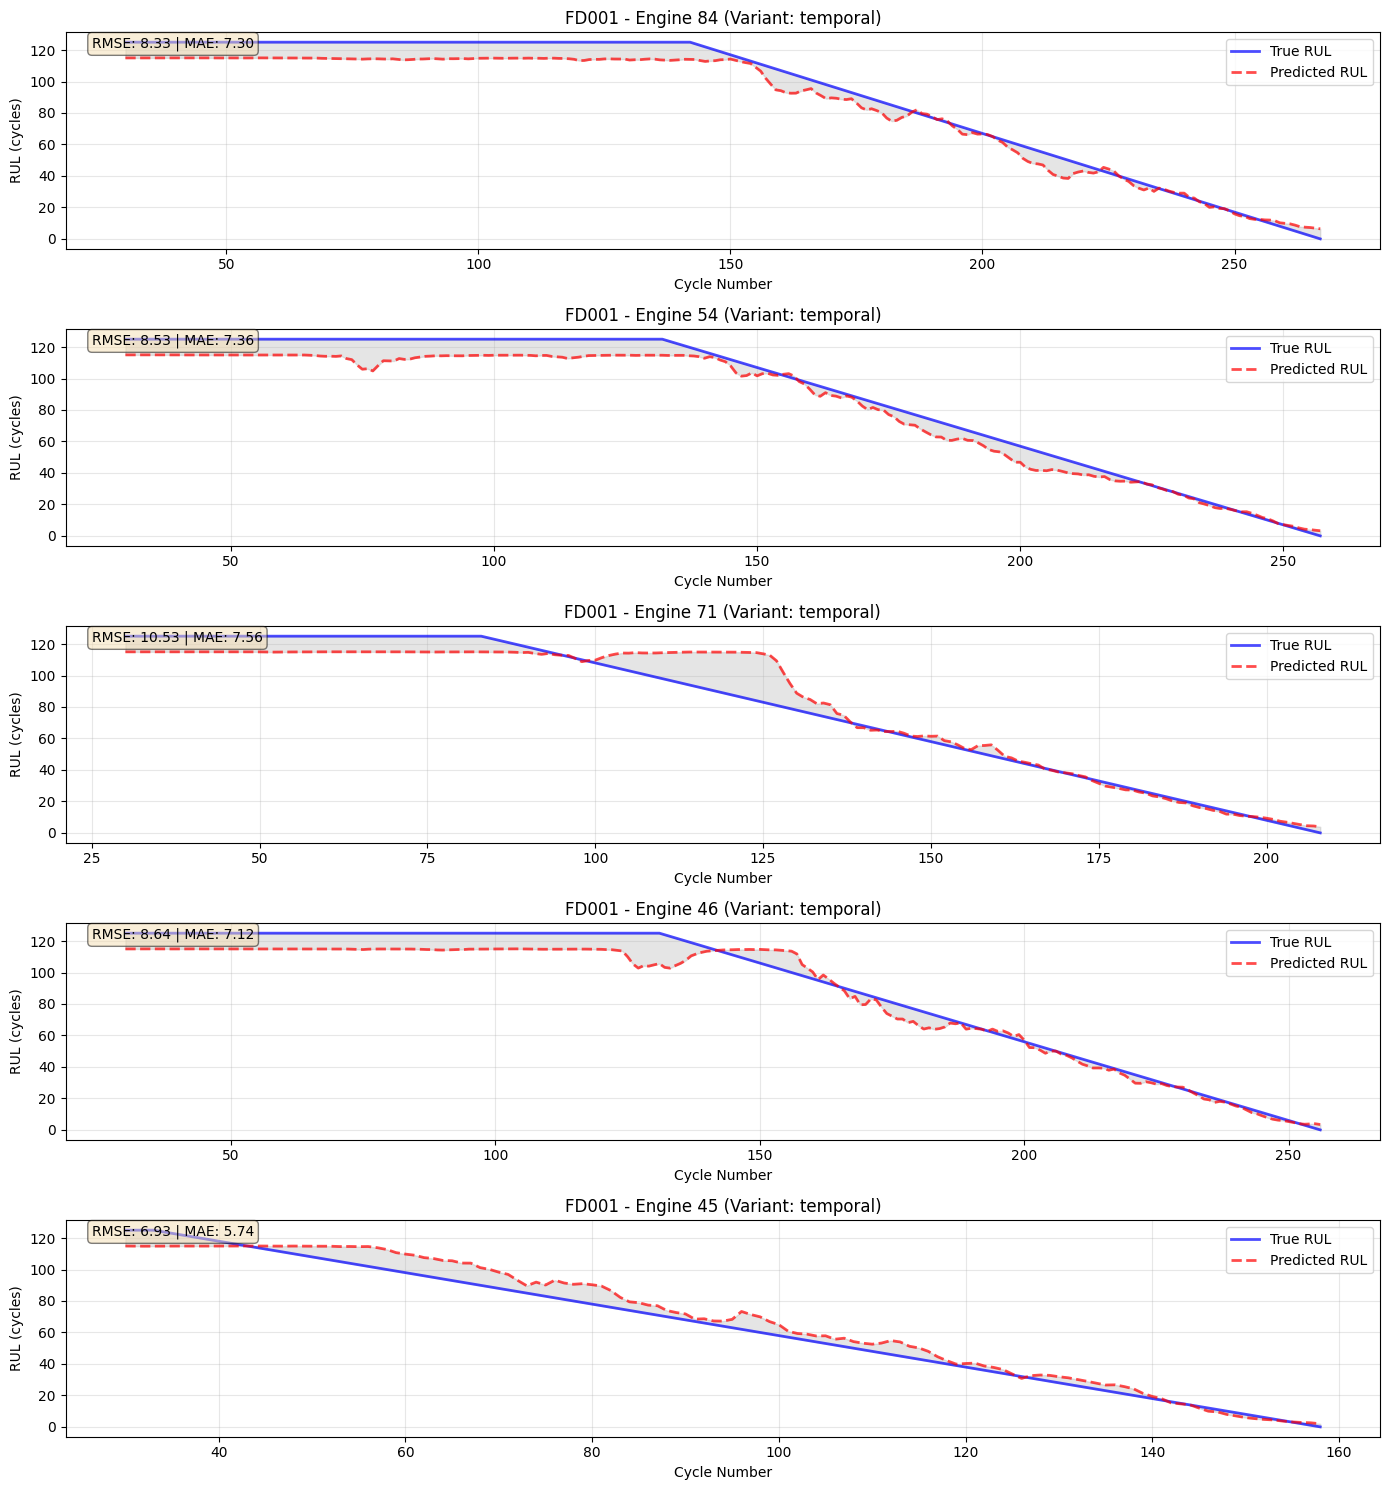


[FD001] Trajectory plots shown for 5 sample engines

[FD002] Using best variant: baseline (RMSE: 21.5971)
  Loading training data for FD002...
[ConditionID] Found 7 unique (S1_r, S2_r, S3_r) combos in TRAIN.
[ConditionID] Train ConditionIDs: [0 1 2 3 4 5 6]
[ConditionID] Test  ConditionIDs: [0 1 2 3 4 5 6]
  Building sequences for trajectory plotting...
[build_full_eol_sequences_from_df] Summary
Num units: 260
Using past_len=30, max_rul=125
Num feature cols: 245
X shape: torch.Size([46219, 30, 245]), y shape: torch.Size([46219]), unit_ids shape: torch.Size([46219])
RUL stats (capped at 125): min=0.00, max=125.00, mean=80.74, std=41.80


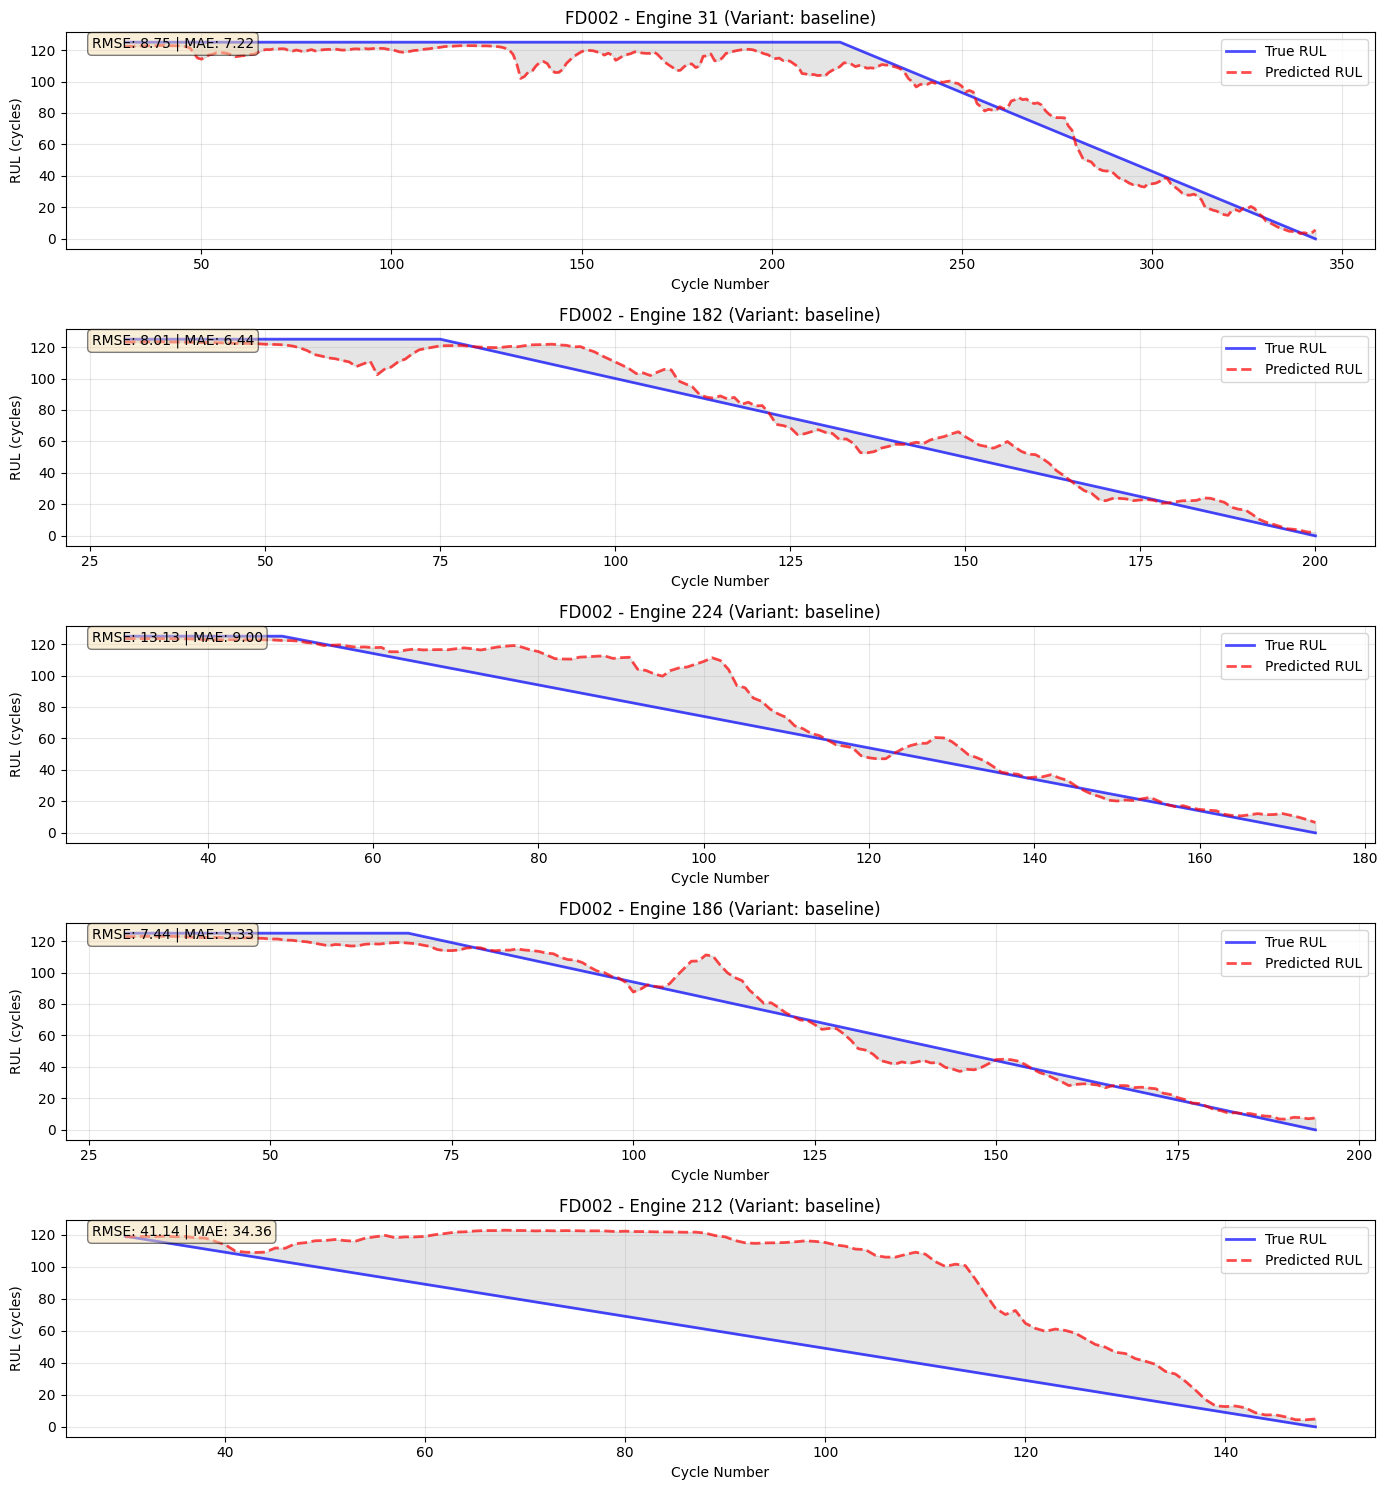


[FD002] Trajectory plots shown for 5 sample engines

[FD003] Using best variant: baseline (RMSE: 11.3473)
  Loading training data for FD003...
  Building sequences for trajectory plotting...
[build_full_eol_sequences_from_df] Summary
Num units: 100
Using past_len=30, max_rul=125
Num feature cols: 245
X shape: torch.Size([21820, 30, 245]), y shape: torch.Size([21820]), unit_ids shape: torch.Size([21820])
RUL stats (capped at 125): min=0.00, max=125.00, mean=88.91, std=41.44


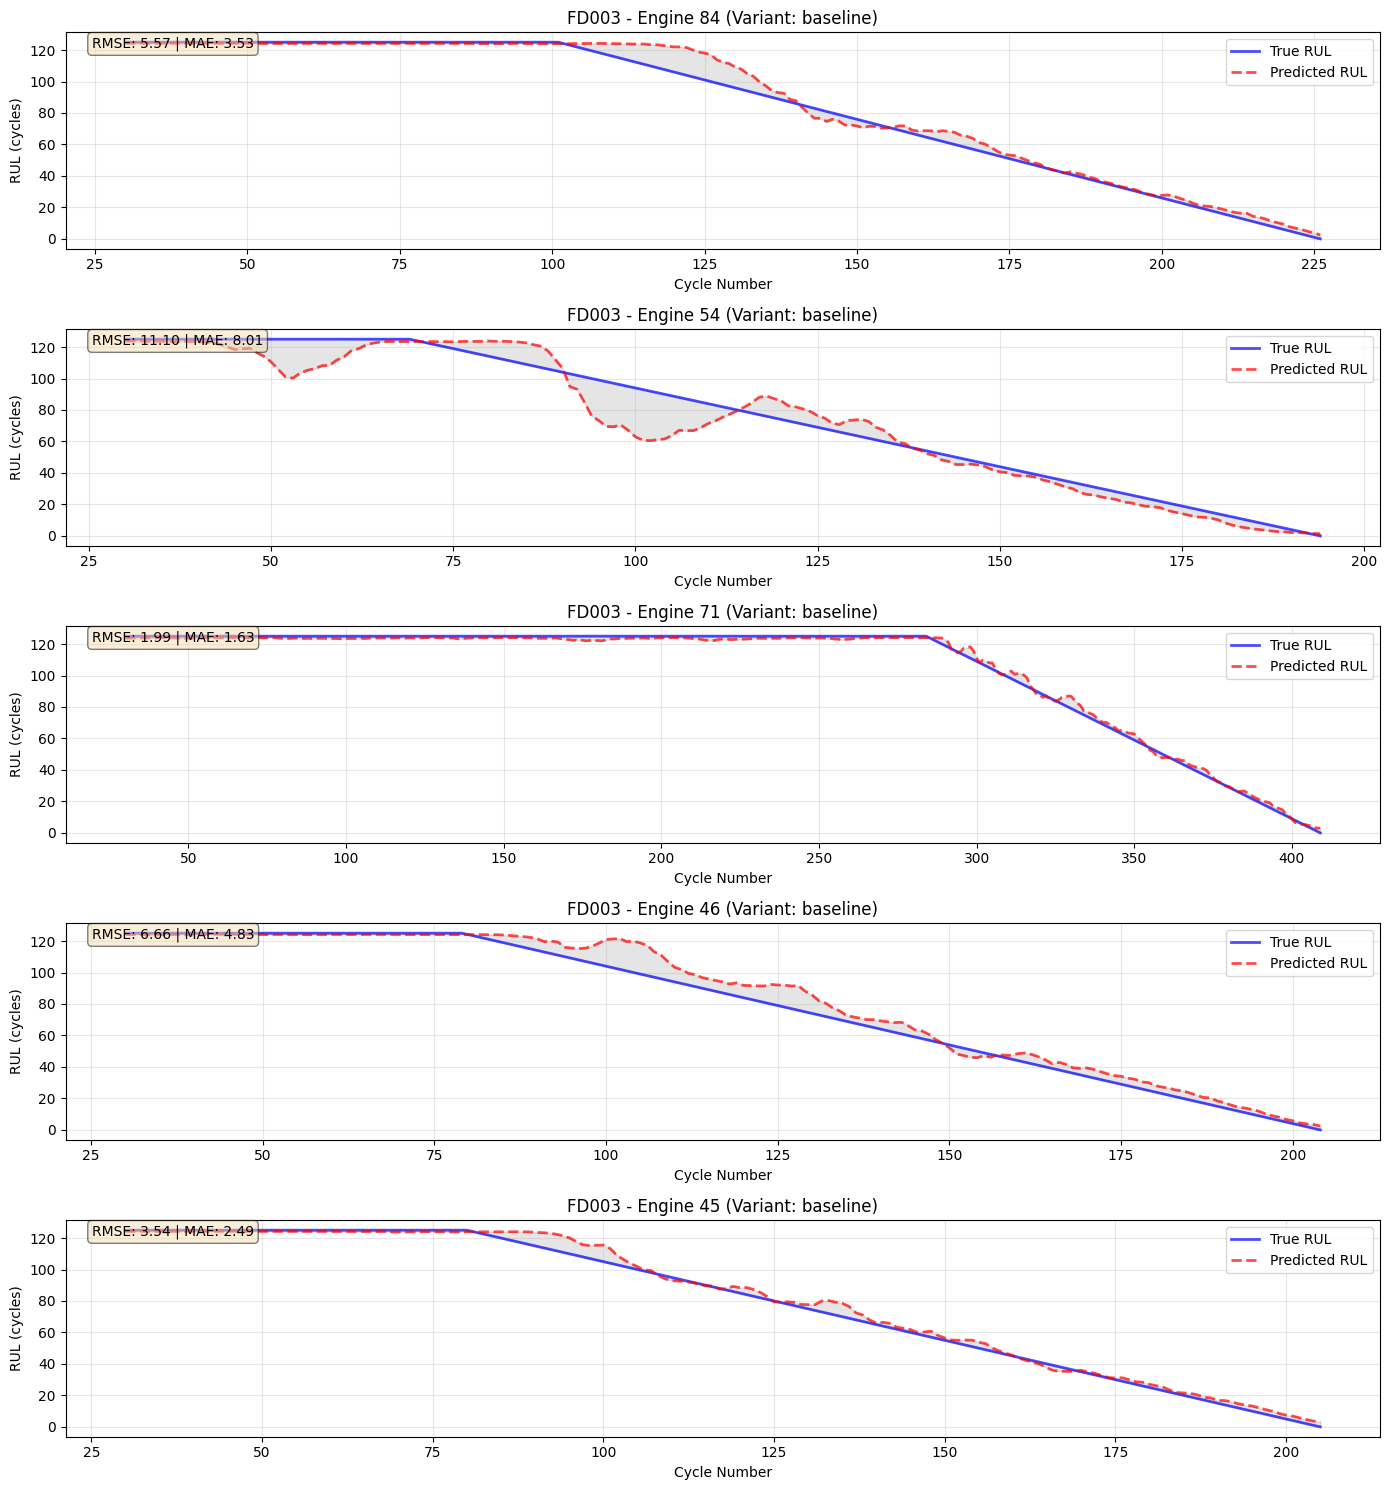


[FD003] Trajectory plots shown for 5 sample engines

[FD004] Using best variant: extended (RMSE: 24.5566)
  Loading training data for FD004...
[ConditionID] Found 7 unique (S1_r, S2_r, S3_r) combos in TRAIN.
[ConditionID] Train ConditionIDs: [0 1 2 3 4 5 6]
[ConditionID] Test  ConditionIDs: [0 1 2 3 4 5 6]
  Building sequences for trajectory plotting...
[build_full_eol_sequences_from_df] Summary
Num units: 249
Using past_len=30, max_rul=125
Num feature cols: 247
X shape: torch.Size([54028, 30, 247]), y shape: torch.Size([54028]), unit_ids shape: torch.Size([54028])
RUL stats (capped at 125): min=0.00, max=125.00, mean=88.73, std=41.48


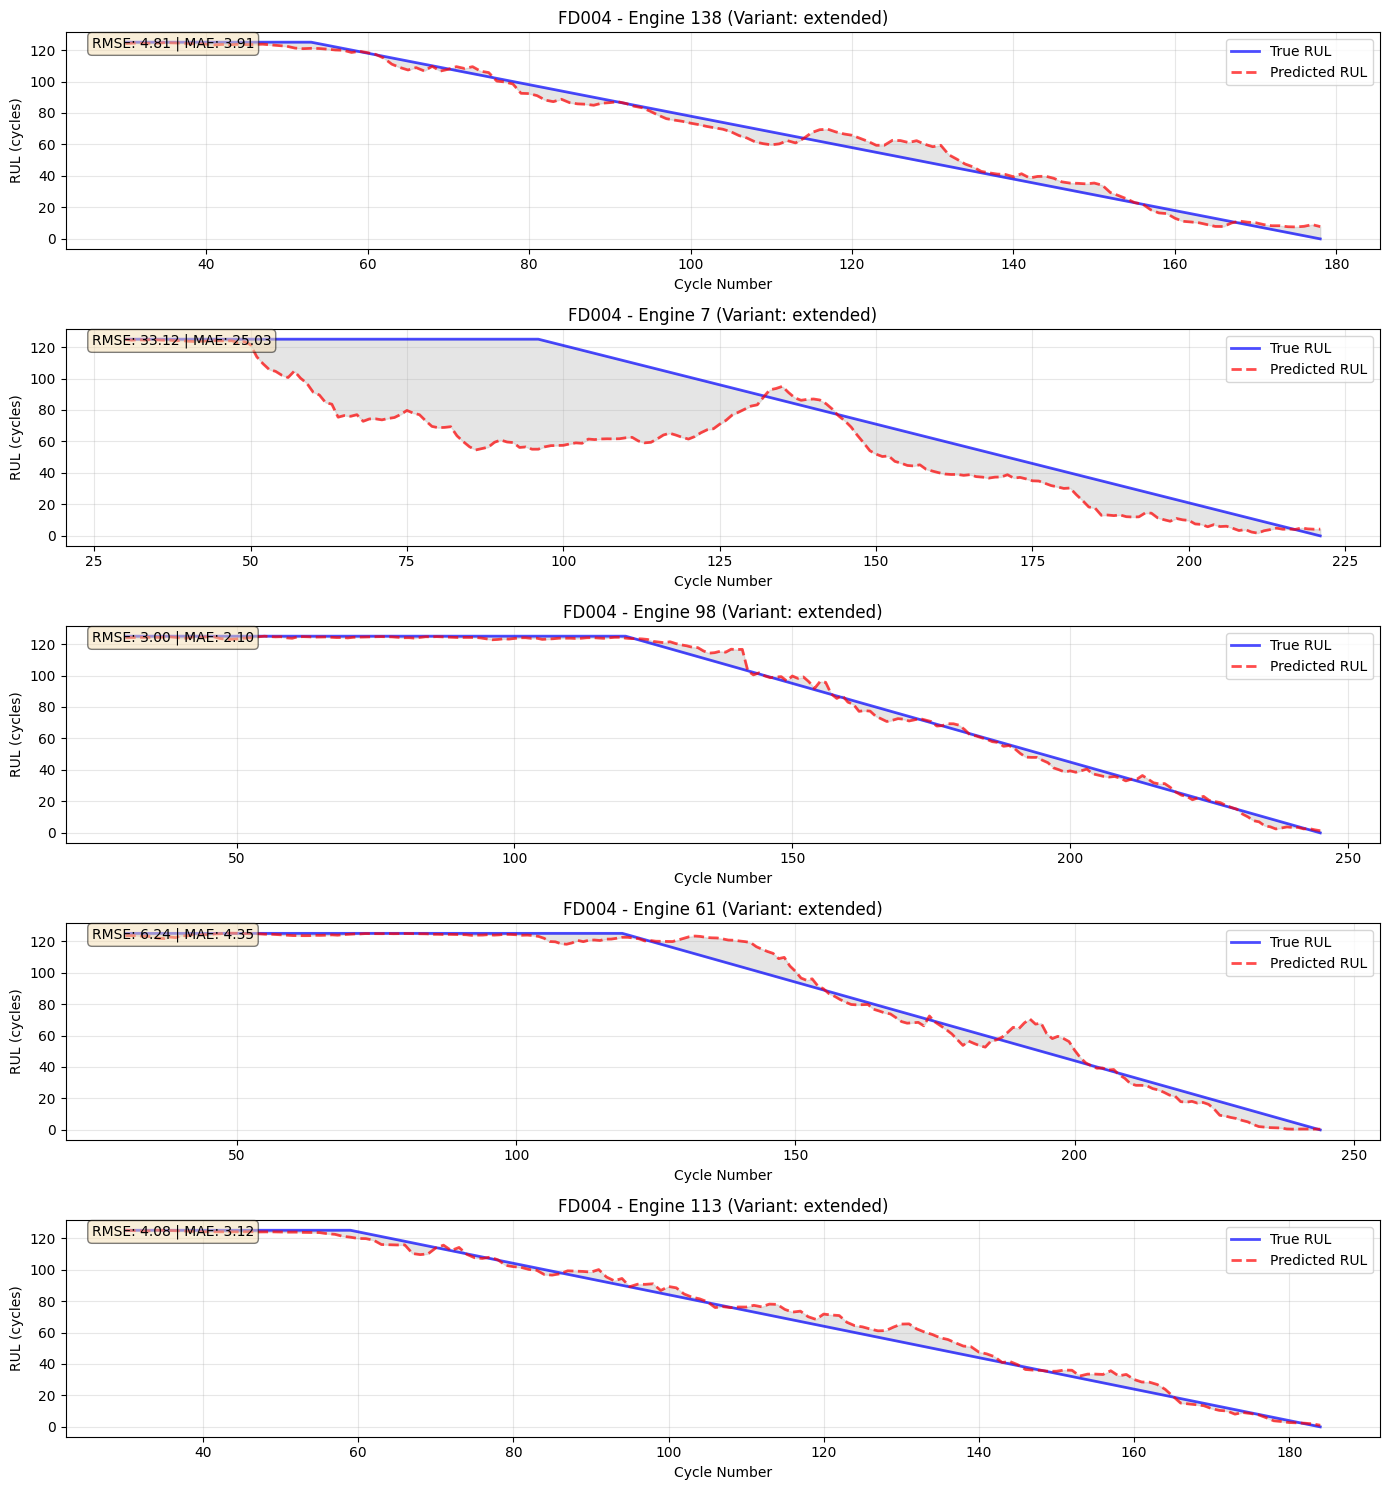


[FD004] Trajectory plots shown for 5 sample engines


In [18]:
# ===================================================================
# RUL Trajectory Plots: RUL over Time for 5 Sample Engines
# ===================================================================
print("\n" + "=" * 80)
print("RUL Trajectory Plots (RUL over Time for 5 Sample Engines)")
print("=" * 80)

# Check if physics_results exists and has data
if 'physics_results' not in globals() or len(physics_results) == 0:
    print("⚠️  No results available. Please run the training cell (Cell 5) first.")
else:
    from src.eol_full_lstm import build_full_eol_sequences_from_df
    
    for fd_id in FD_DATASETS:
        if fd_id not in physics_results:
            continue
        
        # Find best variant (lowest RMSE on test set)
        best_variant = None
        best_rmse = float('inf')
        
        for variant_name in physics_results[fd_id].keys():
            if "metrics" not in physics_results[fd_id][variant_name] or physics_results[fd_id][variant_name]["metrics"] is None:
                continue
            metrics = physics_results[fd_id][variant_name]["metrics"]
            if "pointwise" in metrics:
                rmse = metrics["pointwise"]["rmse"]
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_variant = variant_name
        
        if best_variant is None:
            print(f"\n[{fd_id}] No valid variant found. Skipping...")
            continue
        
        print(f"\n[{fd_id}] Using best variant: {best_variant} (RMSE: {best_rmse:.4f})")
        
        # Get model, scaler, and feature_cols from best variant
        model = physics_results[fd_id][best_variant]["model"]
        scaler = physics_results[fd_id][best_variant]["scaler"]
        feature_cols = physics_results[fd_id][best_variant]["feature_cols"]
        physics_config = physics_results[fd_id][best_variant].get("physics_config", None)
        
        if model is None or scaler is None or feature_cols is None:
            print(f"  ⚠️  Missing model/scaler/features for {fd_id}. Skipping...")
            continue
        
        # Load training data (for trajectory plotting, we need full trajectories with RUL)
        print(f"  Loading training data for {fd_id}...")
        try:
            df_train_plot, _, _ = load_cmapps_subset(
                fd_id,
                max_rul=None,
                clip_train=False,
                clip_test=True,
            )
        except Exception as e:
            print(f"  ⚠️  Could not load training data: {e}")
            continue
        
        # Apply same feature engineering as training
        if physics_config is not None:
            df_train_plot = create_physical_features(
                df_train_plot,
                physics_config=physics_config,
                unit_col="UnitNumber",
                cycle_col="TimeInCycles",
            )
        df_train_plot = create_all_features(
            df_train_plot,
            unit_col="UnitNumber",
            cycle_col="TimeInCycles",
            config=FEATURE_CONFIG,
            inplace=False,
        )
        
        # Build sequences for all cycles (for trajectory plotting)
        print(f"  Building sequences for trajectory plotting...")
        try:
            X_train, y_train, unit_ids_train = build_full_eol_sequences_from_df(
                df=df_train_plot,
                feature_cols=feature_cols,
                past_len=TRAINING_CONFIG["past_len"],
                max_rul=TRAINING_CONFIG["max_rul"],
                unit_col="UnitNumber",
                cycle_col="TimeInCycles",
                rul_col="RUL",
            )
        except Exception as e:
            print(f"  ⚠️  Could not build sequences: {e}")
            continue
        
        # Apply scaling
        X_train_np = X_train.numpy()
        B, T, F = X_train_np.shape
        X_train_flat = X_train_np.reshape(-1, F)
        X_train_scaled = scaler.transform(X_train_flat)
        X_train_scaled = torch.from_numpy(X_train_scaled.reshape(B, T, F)).float()
        
        # Make predictions
        model.eval()
        with torch.no_grad():
            X_train_scaled = X_train_scaled.to(device)
            y_pred_all = model(X_train_scaled).cpu().numpy().flatten()
        
        y_true_all = y_train.numpy().flatten()
        unit_ids_all = unit_ids_train.numpy().flatten()
        
        # Select 5 random engines for plotting
        unique_units = np.unique(unit_ids_all)
        n_sample_engines = min(5, len(unique_units))
        np.random.seed(42)  # For reproducibility
        sample_engines = np.random.choice(unique_units, size=n_sample_engines, replace=False)
        
        # Create trajectory plots
        fig, axes = plt.subplots(n_sample_engines, 1, figsize=(14, 3 * n_sample_engines))
        if n_sample_engines == 1:
            axes = [axes]
        
        for idx, unit_id in enumerate(sample_engines):
            ax = axes[idx]
            
            # Get all samples for this engine
            mask = unit_ids_all == unit_id
            y_true_unit = y_true_all[mask]
            y_pred_unit = y_pred_all[mask]
            
            # Get cycle numbers for this engine (from original data)
            df_engine = df_train_plot[df_train_plot['UnitNumber'] == unit_id].sort_values('TimeInCycles')
            cycles = df_engine['TimeInCycles'].values
            
            # Match predictions to cycles (predictions are for sequences ending at each cycle)
            # We need to align: predictions[i] corresponds to cycle ending at cycles[i]
            # For trajectory, we show predictions for cycles >= past_len
            if len(cycles) >= TRAINING_CONFIG["past_len"]:
                # Predictions start from cycle past_len
                cycles_for_pred = cycles[TRAINING_CONFIG["past_len"]-1:]
                y_true_traj = y_true_unit[:len(cycles_for_pred)]
                y_pred_traj = y_pred_unit[:len(cycles_for_pred)]
            else:
                cycles_for_pred = cycles
                y_true_traj = y_true_unit[:len(cycles_for_pred)]
                y_pred_traj = y_pred_unit[:len(cycles_for_pred)]
            
            # Plot
            ax.plot(cycles_for_pred, y_true_traj, 'b-', label='True RUL', linewidth=2, alpha=0.7)
            ax.plot(cycles_for_pred, y_pred_traj, 'r--', label='Predicted RUL', linewidth=2, alpha=0.7)
            ax.fill_between(cycles_for_pred, y_true_traj, y_pred_traj, alpha=0.2, color='gray')
            
            ax.set_xlabel("Cycle Number")
            ax.set_ylabel("RUL (cycles)")
            ax.set_title(f"{fd_id} - Engine {int(unit_id)} (Variant: {best_variant})")
            ax.grid(True, alpha=0.3)
            ax.legend()
            
            # Calculate RMSE for this engine
            rmse_unit = np.sqrt(np.mean((y_pred_traj - y_true_traj) ** 2))
            mae_unit = np.mean(np.abs(y_pred_traj - y_true_traj))
            ax.text(0.02, 0.98, f"RMSE: {rmse_unit:.2f} | MAE: {mae_unit:.2f}", 
                   transform=ax.transAxes, verticalalignment="top",
                   bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))
        
        plt.tight_layout()
        
        # Display plot in Jupyter
        # With %matplotlib inline, figures are automatically displayed when the cell executes
        # We can also explicitly display using IPython.display
        try:
            from IPython.display import display
            display(fig)
        except (ImportError, NameError):
            # Fallback: plt.show() should work with inline backend
            # Suppress warning about non-interactive backend
            import warnings
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=UserWarning)
                plt.show()
        
        print(f"\n[{fd_id}] Trajectory plots shown for {n_sample_engines} sample engines")
        print("=" * 80)


In [12]:
# ===================================================================
# Visualisierung: RMSE Vergleich (Best Variant per Dataset)
# ===================================================================

# Check if physics_results exists and has data
if 'physics_results' not in globals() or len(physics_results) == 0:
    print("⚠️  No results available. Please run the training cell (Cell 5) first.")
else:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Pointwise RMSE - Best variant per dataset
    ax1 = axes[0]
    pointwise_rmse = []
    pointwise_labels = []
    
    for fd in FD_DATASETS:
        if fd not in physics_results:
            continue
        
        # Find best variant (lowest RMSE)
        best_rmse = float('inf')
        for variant_name in physics_results[fd].keys():
            if "metrics" not in physics_results[fd][variant_name] or physics_results[fd][variant_name]["metrics"] is None:
                continue
            metrics = physics_results[fd][variant_name]["metrics"]
            if "pointwise" in metrics:
                rmse = metrics["pointwise"]["rmse"]
                if rmse < best_rmse:
                    best_rmse = rmse
        
        if best_rmse != float('inf'):
            pointwise_rmse.append(best_rmse)
            pointwise_labels.append(fd)
    
    if len(pointwise_rmse) > 0:
        bars1 = ax1.bar(pointwise_labels, pointwise_rmse, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'][:len(pointwise_rmse)])
        ax1.set_ylabel("RMSE (cycles)")
        ax1.set_title("Pointwise RMSE (Test Set - Best Variant)")
        ax1.grid(True, alpha=0.3)
        for i, (fd, val) in enumerate(zip(pointwise_labels, pointwise_rmse)):
            ax1.text(i, val, f"{val:.2f}", ha='center', va='bottom')
    
    # EOL RMSE (falls verfügbar)
    ax2 = axes[1]
    eol_rmse = []
    eol_labels = []
    
    for fd in FD_DATASETS:
        if fd not in physics_results:
            continue
        
        # Find best variant with EOL metrics
        best_eol_rmse = float('inf')
        for variant_name in physics_results[fd].keys():
            if "metrics" not in physics_results[fd][variant_name] or physics_results[fd][variant_name]["metrics"] is None:
                continue
            metrics = physics_results[fd][variant_name]["metrics"]
            if "eol" in metrics:
                rmse = metrics["eol"]["rmse"]
                if rmse < best_eol_rmse:
                    best_eol_rmse = rmse
        
        if best_eol_rmse != float('inf'):
            eol_rmse.append(best_eol_rmse)
            eol_labels.append(fd)
    
    if len(eol_rmse) > 0:
        bars2 = ax2.bar(eol_labels, eol_rmse, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'][:len(eol_rmse)])
        ax2.set_ylabel("RMSE (cycles)")
        ax2.set_title("EOL RMSE (Test Set - Best Variant)")
        ax2.grid(True, alpha=0.3)
        for i, (fd, val) in enumerate(zip(eol_labels, eol_rmse)):
            ax2.text(i, val, f"{val:.2f}", ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()


C:\Users\rober\AppData\Local\Temp\ipykernel_13484\3959760481.py:76: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [13]:
# ===================================================================
# Visualisierung: NASA Score Vergleich
# ===================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pointwise NASA Score (mean)
ax1 = axes[0]
nasa_point_mean = []
for fd in FD_DATASETS:
    if "nasa_pointwise" in results_dict[fd]["metrics"]:
        nasa_point_mean.append(results_dict[fd]["metrics"]["nasa_pointwise"]["score_mean"])
    elif "nasa_test" in results_dict[fd]["metrics"]:
        nasa_point_mean.append(results_dict[fd]["metrics"]["nasa_test"]["score_mean"])
    else:
        nasa_point_mean.append(0.0)
bars1 = ax1.bar(FD_DATASETS, nasa_point_mean, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
ax1.set_ylabel("NASA Score (mean)")
ax1.set_title("Pointwise NASA Score (mean, all validation samples)")
ax1.grid(True, alpha=0.3)
for i, (fd, val) in enumerate(zip(FD_DATASETS, nasa_point_mean)):
    ax1.text(i, val, f"{val:.2f}", ha='center', va='bottom')

# EOL NASA Score (mean, falls verfügbar)
ax2 = axes[1]
eol_nasa_mean = []
eol_labels = []
for fd in FD_DATASETS:
    if "eol" in results_dict[fd]["metrics"]:
        eol_nasa_mean.append(results_dict[fd]["metrics"]["eol"]["nasa_score_mean"])
        eol_labels.append(fd)
    else:
        eol_nasa_mean.append(0)
        eol_labels.append(fd)

if any(eol_nasa_mean):
    bars2 = ax2.bar(eol_labels, eol_nasa_mean, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    ax2.set_ylabel("NASA Score (mean)")
    ax2.set_title("EOL NASA Score (mean, per engine)")
    ax2.grid(True, alpha=0.3)
    for i, (fd, val) in enumerate(zip(eol_labels, eol_nasa_mean)):
        if val != 0:
            ax2.text(i, val, f"{val:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


TypeError: argument of type 'NoneType' is not iterable

## Feature Engineering Konfigurationen für Sensitivitätsanalyse

Unten sind verschiedene Feature-Konfigurationen, die du für Ablation Studies verwenden kannst:

### Beispiel 1: Nur physikalische Features (keine Temporal)
```python
cfg_phys_only = FeatureConfig(
    add_physical_core=True,
    add_temporal_features=False
)
```

### Beispiel 2: Nur Temporal Features auf physikalischen Features
```python
cfg_temp_on_phys = FeatureConfig(
    add_physical_core=True,
    add_temporal_features=True,
    temporal=TemporalFeatureConfig(
        base_cols=[
            "Effizienz_HPC_Proxy",
            "EGT_Drift",
            "Fan_HPC_Ratio",
        ],
        short_windows=(5, 10),
        long_windows=(30,),
        add_rolling_mean=True,
        add_trend=True,
        add_delta=False,
    ),
)
```

### Beispiel 3: Ablation - nur Rolling-Mean, kein Trend/Delta
```python
cfg_ablation = FeatureConfig(
    add_physical_core=True,
    add_temporal_features=True,
    temporal=TemporalFeatureConfig(
        base_cols=None,  # Auto-infer
        short_windows=(5,),
        long_windows=(30,),
        add_rolling_mean=True,
        add_rolling_std=False,
        add_trend=False,
        add_delta=False,
    ),
)
```

### Beispiel 4: Nur Temporal auf Rohsensoren (keine physikalischen Features)
```python
cfg_temp_raw = FeatureConfig(
    add_physical_core=False,
    add_temporal_features=True,
    temporal=TemporalFeatureConfig(
        base_cols=None,  # Auto-infer (wird Sensoren finden)
        short_windows=(5, 10),
        long_windows=(30,),
        add_rolling_mean=True,
        add_trend=True,
        add_delta=True,
        delta_lags=(5, 10),
    ),
)
```


In [ ]:
# ===================================================================
# Quick Test: Feature Engineering Verification
# ===================================================================
# Test the feature engineering on a small sample to verify it works
print("=" * 60)
print("Feature Engineering Verification Test")
print("=" * 60)

# Load a small sample
df_test_sample, _, _ = load_cmapps_subset("FD001", max_rul=None, clip_train=False, clip_test=True)
df_test_sample = df_test_sample.head(1000).copy()  # Small sample for quick test

print(f"\nOriginal columns: {len(df_test_sample.columns)}")
print(f"Original columns: {list(df_test_sample.columns[:10])}...")

# Test with full config
df_test_processed = create_all_features(
    df_test_sample.copy(),
    unit_col="UnitNumber",
    cycle_col="TimeInCycles",
    config=FEATURE_CONFIG,
    inplace=False,
)

print(f"\nAfter feature engineering: {len(df_test_processed.columns)} columns")
print(f"New columns (sample): {[c for c in df_test_processed.columns if c not in df_test_sample.columns][:10]}...")

# Check for temporal features
temporal_cols = [c for c in df_test_processed.columns if any(x in c for x in ['_roll_mean_', '_trend_', '_delta_'])]
print(f"\nTemporal features created: {len(temporal_cols)}")
if len(temporal_cols) > 0:
    print(f"Sample temporal features: {temporal_cols[:5]}...")

print("\n" + "=" * 60)
print("✓ Feature engineering verification complete!")
print("=" * 60)


Feature Engineering Verification Test

Original columns: 30
Original columns: ['UnitNumber', 'TimeInCycles', 'Setting1', 'Setting2', 'Setting3', 'Sensor1', 'Sensor2', 'Sensor3', 'Sensor4', 'Sensor5']...
New columns successfully added. Current number of columns: 33
   Effizienz_HPC_Proxy  EGT_Drift  Fan_HPC_Ratio  RUL
0             0.941013        0.2       0.403737  191
1             0.943169        0.2       0.403406  190
2             0.942554       -1.8       0.404505  189
3             0.943025        0.2       0.405834  188
4             0.942581        1.2       0.405831  187

After feature engineering: 249 columns
New columns (sample): ['Effizienz_HPC_Proxy', 'EGT_Drift', 'Fan_HPC_Ratio', 'Setting1_roll_mean_5', 'Setting1_trend_5', 'Setting1_roll_mean_10', 'Setting1_trend_10', 'Setting1_roll_mean_30', 'Setting1_trend_30', 'Setting1_delta_5']...

Temporal features created: 216
Sample temporal features: ['Setting1_roll_mean_5', 'Setting1_trend_5', 'Setting1_roll_mean_10', 'Setting


RUL Prediction Plots


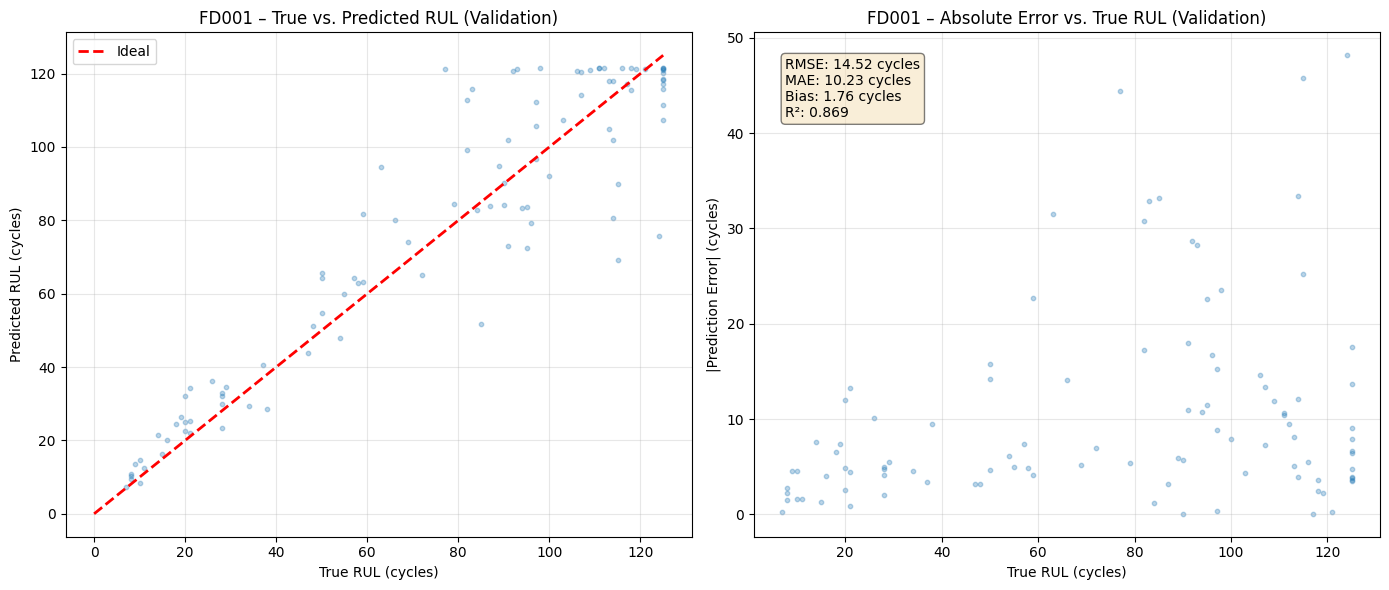

KeyError: 'y_true_eol'

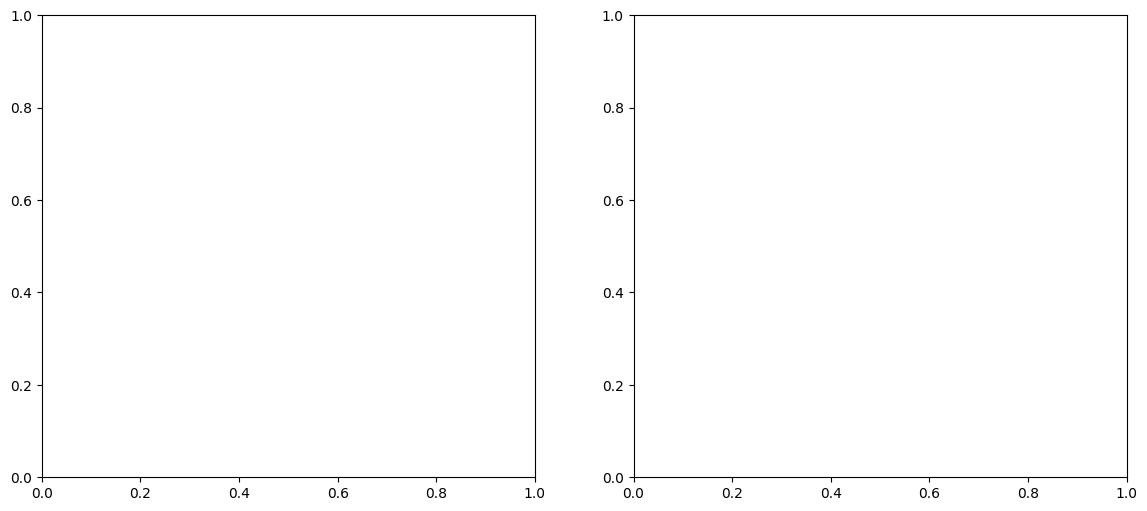

In [ ]:
# ===================================================================
# RUL Prediction Plots für jedes Dataset
# ===================================================================
print("\n" + "=" * 80)
print("RUL Prediction Plots")
print("=" * 80)

for fd_id in FD_DATASETS:
    if results_dict[fd_id]["metrics"] is None:
        continue
    
    metrics = results_dict[fd_id]["metrics"]
    y_true = metrics["y_true"]
    y_pred = metrics["y_pred"]
    
    # Scatterplot: True vs Predicted
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: True vs Predicted
    axes[0].scatter(y_true, y_pred, alpha=0.3, s=10)
    max_rul = max(y_true.max(), y_pred.max())
    axes[0].plot([0, max_rul], [0, max_rul], linestyle="--", color="red", linewidth=2, label="Ideal")
    axes[0].set_xlabel("True RUL (cycles)")
    axes[0].set_ylabel("Predicted RUL (cycles)")
    axes[0].set_title(f"{fd_id} – True vs. Predicted RUL (Validation)")
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()
    
    # Plot 2: Absolute Error vs True RUL
    errors = y_pred - y_true
    abs_errors = np.abs(errors)
    
    axes[1].scatter(y_true, abs_errors, alpha=0.3, s=10)
    axes[1].set_xlabel("True RUL (cycles)")
    axes[1].set_ylabel("|Prediction Error| (cycles)")
    axes[1].set_title(f"{fd_id} – Absolute Error vs. True RUL (Validation)")
    axes[1].grid(True, alpha=0.3)
    
    # Statistik-Text
    m_point = metrics["pointwise"]
    stats_text = (
        f"RMSE: {m_point['rmse']:.2f} cycles\n"
        f"MAE: {m_point['mae']:.2f} cycles\n"
        f"Bias: {m_point['bias']:.2f} cycles\n"
        f"R²: {m_point['r2']:.3f}"
    )
    axes[1].text(
        0.05, 0.95, stats_text, transform=axes[1].transAxes,
        verticalalignment="top", bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5)
    )
    
    plt.tight_layout()
    plt.show()
    
    # EOL Metrics Plot (falls verfügbar)
    if "eol" in metrics:
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        y_true_eol = metrics["eol"]["y_true_eol"]
        y_pred_eol = metrics["eol"]["y_pred_eol"]
        errors_eol = y_pred_eol - y_true_eol
        
        # Plot 1: EOL True vs Predicted
        axes[0].scatter(y_true_eol, y_pred_eol, alpha=0.5, s=30)
        max_rul_eol = max(y_true_eol.max(), y_pred_eol.max())
        axes[0].plot([0, max_rul_eol], [0, max_rul_eol], linestyle="--", color="red", linewidth=2, label="Ideal")
        axes[0].set_xlabel("True RUL (cycles)")
        axes[0].set_ylabel("Predicted RUL (cycles)")
        axes[0].set_title(f"{fd_id} – EOL: True vs. Predicted RUL (per Engine)")
        axes[0].grid(True, alpha=0.3)
        axes[0].legend()
        
        # Plot 2: EOL Error Distribution
        axes[1].hist(errors_eol, bins=30, alpha=0.7, edgecolor="black")
        axes[1].axvline(0, color="red", linestyle="--", linewidth=2, label="Zero Error")
        axes[1].set_xlabel("Prediction Error (cycles)")
        axes[1].set_ylabel("Frequency")
        axes[1].set_title(f"{fd_id} – EOL: Error Distribution (per Engine)")
        axes[1].grid(True, alpha=0.3)
        axes[1].legend()
        
        # EOL Statistik-Text
        m_eol = metrics["eol"]
        stats_text_eol = (
            f"RMSE_eol: {m_eol['rmse']:.2f} cycles\n"
            f"MAE_eol: {m_eol['mae']:.2f} cycles\n"
            f"Bias_eol: {m_eol['bias']:.2f} cycles\n"
            f"NASA Score: {m_eol['nasa_score_mean']:.2f}"
        )
        axes[1].text(
            0.05, 0.95, stats_text_eol, transform=axes[1].transAxes,
            verticalalignment="top", bbox=dict(boxstyle="round", facecolor="lightblue", alpha=0.5)
        )
        
        plt.tight_layout()
        plt.show()

print("\n" + "=" * 80)
print("Plots complete!")
print("=" * 80)

# ===================================================================
# RUL Trajectory Plots: RUL over Time for Sample Engines
# ===================================================================
print("\n" + "=" * 80)
print("RUL Trajectory Plots (RUL over Time for Sample Engines)")
print("=" * 80)

for fd_id in FD_DATASETS + ["FD001_FD004"]:
    if results_dict[fd_id]["metrics"] is None:
        continue
    
    metrics = results_dict[fd_id]["metrics"]
    
    # Check if we have unit_ids for trajectory plotting
    if "unit_ids" in metrics:
        unit_ids = metrics["unit_ids"]
        y_true = metrics["y_true"]
        y_pred = metrics["y_pred"]
        
        # Select a few sample engines for plotting
        unique_units = np.unique(unit_ids)
        n_sample_engines = min(6, len(unique_units))
        sample_engines = np.random.choice(unique_units, size=n_sample_engines, replace=False)
        
        # Create trajectory plots
        n_cols = 3
        n_rows = (n_sample_engines + n_cols - 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
        if n_rows == 1:
            axes = axes.reshape(1, -1)
        
        for idx, unit_id in enumerate(sample_engines):
            row = idx // n_cols
            col = idx % n_cols
            ax = axes[row, col]
            
            # Get all samples for this engine
            mask = unit_ids == unit_id
            y_true_unit = y_true[mask]
            y_pred_unit = y_pred[mask]
            
            # Sort by true RUL (descending, to show degradation over time)
            sort_idx = np.argsort(-y_true_unit)  # Negative for descending
            y_true_unit_sorted = y_true_unit[sort_idx]
            y_pred_unit_sorted = y_pred_unit[sort_idx]
            
            # Create cycle indices (reverse order to show time progression)
            cycles = np.arange(len(y_true_unit_sorted))
            
            # Plot
            ax.plot(cycles, y_true_unit_sorted, 'b-', label='True RUL', linewidth=2, alpha=0.7)
            ax.plot(cycles, y_pred_unit_sorted, 'r--', label='Predicted RUL', linewidth=2, alpha=0.7)
            ax.fill_between(cycles, y_true_unit_sorted, y_pred_unit_sorted, alpha=0.2, color='gray')
            
            ax.set_xlabel("Sample Index (time progression)")
            ax.set_ylabel("RUL (cycles)")
            ax.set_title(f"Engine {int(unit_id)} - {fd_id}")
            ax.grid(True, alpha=0.3)
            ax.legend()
            
            # Calculate RMSE for this engine
            rmse_unit = np.sqrt(np.mean((y_pred_unit - y_true_unit) ** 2))
            ax.text(0.05, 0.95, f"RMSE: {rmse_unit:.2f}", transform=ax.transAxes,
                   verticalalignment="top", bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))
        
        # Hide unused subplots
        for idx in range(n_sample_engines, n_rows * n_cols):
            row = idx // n_cols
            col = idx % n_cols
            axes[row, col].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n[{fd_id}] Trajectory plots shown for {n_sample_engines} sample engines")
    else:
        print(f"\n[{fd_id}] Unit IDs not available for trajectory plotting")
        print(f"  Pointwise predictions: {len(metrics['y_true'])} samples")
        print(f"  Pointwise RMSE: {metrics['pointwise']['rmse']:.2f} cycles")


## Ablation Study: Systematische Feature-Ablation

Dieser Block führt eine systematische Ablation-Studie durch:
- 5 verschiedene Feature-Konfigurationen
- Über alle 4 Datasets (FD001-FD004)
- Gesamt: 20 Training-Runs
- Ergebnisse werden in CSV gespeichert: `results/ablation/eol_lstm_ablation_metrics.csv`


In [ ]:
# ===================================================================
# Zusammenfassung
# ===================================================================
print("\n" + "=" * 80)
print("TRAINING COMPLETE - Summary")
print("=" * 80)
print(f"\nTrained {len(FD_DATASETS)} separate models + 1 combined model:")
for fd_id in FD_DATASETS + ["FD001_FD004"]:
    if results_dict[fd_id]["metrics"] is not None:
        m_point = results_dict[fd_id]["metrics"]["pointwise"]
        print(f"  {fd_id}: RMSE={m_point['rmse']:.4f}, MAE={m_point['mae']:.4f}, R²={m_point['r2']:.4f}")

print("\n" + "=" * 80)
print("All results stored in 'results_dict' dictionary")
print("=" * 80)



TRAINING COMPLETE - Summary

Trained 4 separate models + 1 combined model:
  FD001: RMSE=13.1249, MAE=9.9952, R²=0.9006
  FD002: RMSE=23.1323, MAE=17.7425, R²=0.6932
  FD003: RMSE=11.4541, MAE=7.0919, R²=0.9233
  FD004: RMSE=22.8840, MAE=14.7136, R²=0.6930
  FD001_FD004: RMSE=22.1860, MAE=15.9344, R²=0.7134

All results stored in 'results_dict' dictionary


In [ ]:
# ===================================================================
# Ablation Study: Main Loop
# ===================================================================

# Define ABLATION_DATASETS if not already defined
try:
    ABLATION_DATASETS
except NameError:
    # Use FD_DATASETS if available, otherwise define default
    try:
        ABLATION_DATASETS = FD_DATASETS
    except NameError:
        ABLATION_DATASETS = ["FD001", "FD002", "FD003", "FD004"]

ablation_records = []

for dataset_name in ABLATION_DATASETS:
    print(f"\n{'='*80}")
    print(f"Processing {dataset_name}")
    print(f"{'='*80}")

    # Load data
    print(f"\n[{dataset_name}] Loading data...")
    df_train_abl, _, _ = load_cmapps_subset(
        dataset_name,
        max_rul=None,
        clip_train=False,
        clip_test=True,
    )

    # Add FD_ID
    fd_id_map = {"FD001": 0, "FD002": 1, "FD003": 2, "FD004": 3}
    df_train_abl["FD_ID"] = fd_id_map[dataset_name]

    # Apply physics features (always, as base)
    df_train_abl = create_physical_features(df_train_abl)

    for abl in ABLATIONS:
        abl_name = abl["name"]
        cfg = abl["cfg"]

        print(f"\n[{dataset_name}] Ablation: {abl_name}")
        print("-" * 80)

        # Apply temporal window features if needed
        df_abl = df_train_abl.copy()
        if cfg.use_temporal_windows:
            print(f"  Adding temporal window features...")
            df_abl = add_temporal_window_features(
                df_abl,
                unit_col="UnitNumber",
                cycle_col="TimeInCycles",
                temporal_cfg=cfg.temporal_cfg,
            )

        # Get feature columns
        feature_cols = get_feature_columns(df_abl, cfg)
        feature_cols, leaked = remove_rul_leakage(feature_cols)

        if leaked:
            print(f"  ⚠️  Removed RUL leakage: {leaked}")

        print(f"  Using {len(feature_cols)} features")

        # Build sequences
        X_full, y_full, unit_ids_full = build_full_eol_sequences_from_df(
            df=df_abl,
            feature_cols=feature_cols,
            past_len=ABLATION_TRAINING_CONFIG["past_len"],
            max_rul=ABLATION_TRAINING_CONFIG["max_rul"],
            unit_col="UnitNumber",
            cycle_col="TimeInCycles",
            rul_col="RUL",
        )

        # Create dataloaders
        train_loader, val_loader, scaler, _, _ = create_full_dataloaders(
            X=X_full,
            y=y_full,
            unit_ids=unit_ids_full,
            batch_size=ABLATION_TRAINING_CONFIG["batch_size"],
            engine_train_ratio=ABLATION_TRAINING_CONFIG["engine_train_ratio"],
            shuffle_engines=True,
            random_seed=42,
        )

        # Initialize model
        model = EOLFullLSTM(
            input_dim=len(feature_cols),
            hidden_dim=ABLATION_TRAINING_CONFIG["hidden_dim"],
            num_layers=ABLATION_TRAINING_CONFIG["num_layers"],
            dropout=ABLATION_TRAINING_CONFIG["dropout"],
            bidirectional=ABLATION_TRAINING_CONFIG["bidirectional"],
        )

        # Train
        print(f"  Training...")
        model, history = train_eol_full_lstm(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            num_epochs=ABLATION_TRAINING_CONFIG["num_epochs"],
            lr=ABLATION_TRAINING_CONFIG["lr"],
            weight_decay=ABLATION_TRAINING_CONFIG["weight_decay"],
            patience=ABLATION_TRAINING_CONFIG["patience"],
            device=device,
            results_dir=f"../results/ablation/{dataset_name.lower()}/{abl_name}",
            run_name=f"{dataset_name.lower()}_{abl_name}",
        )

        # Evaluate
        print(f"  Evaluating...")
        metrics = evaluate_eol_full_lstm(
            model=model,
            val_loader=val_loader,
            device=device,
        )

        # Extract metrics
        m_point = metrics["pointwise"]
        # NASA Score: Prüfe ob nasa_pointwise vorhanden, sonst nasa_test
        if "nasa_pointwise" in metrics:
            m_nasa_point = metrics["nasa_pointwise"]
        elif "nasa_test" in metrics:
            m_nasa_point = metrics["nasa_test"]
        else:
            m_nasa_point = {"score_mean": 0.0}

        # Build record
        record = {
            "dataset": dataset_name,
            "ablation_name": abl_name,
            "num_features": len(feature_cols),
            "rmse_point": m_point["rmse"],
            "mae_point": m_point["mae"],
            "r2_point": m_point["r2"],
            "nasa_point_mean": m_nasa_point["score_mean"],
            "use_settings": cfg.use_settings,
            "use_sensors": cfg.use_sensors,
            "use_physics_core": cfg.use_physics_core,
            "use_temporal_windows": cfg.use_temporal_windows,
            "use_condition_id": cfg.use_condition_id,
            "short_windows": (
                list(cfg.temporal_cfg.short_windows) if cfg.use_temporal_windows else []
            ),
            "long_windows": (
                list(cfg.temporal_cfg.long_windows) if cfg.use_temporal_windows else []
            ),
        }

        # Add EOL metrics if available
        if "eol" in metrics:
            m_eol = metrics["eol"]
            record.update({
                "rmse_eol": m_eol["rmse"],
                "mae_eol": m_eol["mae"],
                "nasa_eol_sum": m_eol["nasa_score_sum"],
                "nasa_eol_mean": m_eol["nasa_score_mean"],
            })
        else:
            record.update({
                "rmse_eol": None,
                "mae_eol": None,
                "nasa_eol_sum": None,
                "nasa_eol_mean": None,
            })

        ablation_records.append(record)
        print(f"  ✓ Completed: RMSE_point={m_point['rmse']:.4f}, RMSE_eol={record.get('rmse_eol', 'N/A')}")

print(f"\n{'='*80}")
print("Ablation Study Complete!")
print(f"{'='*80}")


NameError: name 'ABLATION_DATASETS' is not defined

In [ ]:
# ===================================================================
# Ablation Study: Save Results to CSV
# ===================================================================
print("\n" + "=" * 80)
print("Saving Ablation Results...")
print("=" * 80)

df_ablation = pd.DataFrame.from_records(ablation_records)
out_dir = Path("../results/ablation")
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / "eol_lstm_ablation_metrics.csv"
df_ablation.to_csv(out_path, index=False)

print(f"\nResults saved to: {out_path}")
print(f"Total records: {len(ablation_records)}")
print("\nAblation Summary:")
print(df_ablation[["dataset", "ablation_name", "rmse_point", "rmse_eol", "num_features"]].to_string(index=False))
print("\n" + "=" * 80)


In [ ]:
# ===================================================================
# Ablation Study: Visualisierung der Ergebnisse
# ===================================================================

# Define ABLATION_DATASETS if not already defined
try:
    ABLATION_DATASETS
except NameError:
    try:
        ABLATION_DATASETS = FD_DATASETS
    except NameError:
        ABLATION_DATASETS = ["FD001", "FD002", "FD003", "FD004"]

if len(ablation_records) > 0:
    print("\n" + "=" * 80)
    print("Ablation Results Visualization")
    print("=" * 80)
    
    # Plot: RMSE Pointwise pro Dataset und Ablation
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for idx, dataset_name in enumerate(ABLATION_DATASETS):
        ax = axes[idx]
        df_dataset = df_ablation[df_ablation["dataset"] == dataset_name]
        
        x_pos = np.arange(len(df_dataset))
        rmse_values = df_dataset["rmse_point"].values
        
        bars = ax.bar(x_pos, rmse_values, alpha=0.7)
        ax.set_xlabel("Ablation Configuration")
        ax.set_ylabel("RMSE (cycles)")
        ax.set_title(f"{dataset_name} - Pointwise RMSE by Ablation")
        ax.set_xticks(x_pos)
        ax.set_xticklabels(df_dataset["ablation_name"], rotation=45, ha="right")
        ax.grid(True, alpha=0.3, axis="y")
        
        # Add value labels on bars
        for i, (bar, val) in enumerate(zip(bars, rmse_values)):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                   f"{val:.2f}", ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Plot: RMSE EOL pro Dataset und Ablation
    if df_ablation["rmse_eol"].notna().any():
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()
        
        for idx, dataset_name in enumerate(ABLATION_DATASETS):
            ax = axes[idx]
            df_dataset = df_ablation[df_ablation["dataset"] == dataset_name]
            df_dataset = df_dataset[df_dataset["rmse_eol"].notna()]
            
            if len(df_dataset) > 0:
                x_pos = np.arange(len(df_dataset))
                rmse_eol_values = df_dataset["rmse_eol"].values
                
                bars = ax.bar(x_pos, rmse_eol_values, alpha=0.7, color="coral")
                ax.set_xlabel("Ablation Configuration")
                ax.set_ylabel("RMSE EOL (cycles)")
                ax.set_title(f"{dataset_name} - EOL RMSE by Ablation")
                ax.set_xticks(x_pos)
                ax.set_xticklabels(df_dataset["ablation_name"], rotation=45, ha="right")
                ax.grid(True, alpha=0.3, axis="y")
                
                # Add value labels on bars
                for i, (bar, val) in enumerate(zip(bars, rmse_eol_values)):
                    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                           f"{val:.2f}", ha='center', va='bottom', fontsize=8)
        
        plt.tight_layout()
        plt.show()
    
    print("\n" + "=" * 80)
    print("Ablation visualization complete!")
    print("=" * 80)


## Sanity Check: Label Leakage Detection

Dieser Block führt umfassende Checks durch, um Label-Leakage zu erkennen:

1. **RUL in Features Check**: Prüft, ob RUL oder RUL-Varianten in den Features sind
2. **Temporal Features Check**: Prüft, ob Temporal-Features Zukunftsinformationen nutzen
3. **Sanity Run**: Vergleich mit Baseline (ohne Temporal Features)


In [ ]:
# ===================================================================
# SANITY CHECK: Vergleich mit Baseline (ohne Temporal Features)
# ===================================================================
print("\n" + "=" * 80)
print("SANITY CHECK: Baseline Comparison (Physical Features Only)")
print("=" * 80)
print("\nThis check runs FD004 with ONLY physical features (no temporal features)")
print("to verify that the excellent results are not due to label leakage.")
print("\nExpected baseline results:")
print("  - Pointwise RMSE: ~15-25 cycles")
print("  - EOL RMSE: ~6-12 cycles")
print("  - R²: ~0.7-0.8")
print("\nIf results are still too good, there may be leakage elsewhere.")
print("=" * 80)

# Create baseline config (only physical features)
BASELINE_CONFIG = FeatureConfig(
    add_physical_core=True,
    add_temporal_features=False,  # NO temporal features
)

print("\nBaseline Configuration:")
print(f"  Physical Core Features: {BASELINE_CONFIG.add_physical_core}")
print(f"  Temporal Features: {BASELINE_CONFIG.add_temporal_features}")

# Run baseline for FD004 only (quick sanity check)
fd_id_sanity = "FD004"
print(f"\nRunning baseline sanity check for {fd_id_sanity}...")

# Load data
df_train_sanity, _, _ = load_cmapps_subset(
    fd_id_sanity,
    max_rul=None,
    clip_train=False,
    clip_test=True,
)

fd_id_map = {"FD001": 0, "FD002": 1, "FD003": 2, "FD004": 3}
df_train_sanity["FD_ID"] = fd_id_map[fd_id_sanity]

# Feature engineering (BASELINE - no temporal)
print(f"\n[{fd_id_sanity}] Baseline Feature Engineering (Physical Only)...")
num_cols_before = len(df_train_sanity.columns)
df_train_sanity = create_all_features(
    df_train_sanity,
    unit_col="UnitNumber",
    cycle_col="TimeInCycles",
    config=BASELINE_CONFIG,
    inplace=False,
)
num_cols_after = len(df_train_sanity.columns)
num_new_features = num_cols_after - num_cols_before
print(f"  Features: {num_cols_before} → {num_cols_after} (+{num_new_features} new features)")

# Check for RUL leakage
rul_related_cols = [col for col in df_train_sanity.columns if "RUL" in col.upper()]
if len(rul_related_cols) > 0:
    print(f"  ⚠️  WARNING: Found RUL-related columns: {rul_related_cols}")

# Feature selection
exclude_cols = {"UnitNumber", "TimeInCycles", "MaxTime", "FD_ID"}
exclude_cols.update(rul_related_cols)
feature_cols_sanity = [
    col
    for col in df_train_sanity.columns
    if col not in exclude_cols and pd.api.types.is_numeric_dtype(df_train_sanity[col])
]

# Final RUL check
rul_in_features = [c for c in feature_cols_sanity if "RUL" in c.upper()]
if len(rul_in_features) > 0:
    print(f"  ⚠️  CRITICAL: RUL in features: {rul_in_features}")
    feature_cols_sanity = [c for c in feature_cols_sanity if c not in rul_in_features]

print(f"  Using {len(feature_cols_sanity)} features for baseline")

# Build sequences
X_sanity, y_sanity, unit_ids_sanity = build_full_eol_sequences_from_df(
    df=df_train_sanity,
    feature_cols=feature_cols_sanity,
    past_len=TRAINING_CONFIG["past_len"],
    max_rul=TRAINING_CONFIG["max_rul"],
    unit_col="UnitNumber",
    cycle_col="TimeInCycles",
    rul_col="RUL",
)

# Create dataloaders
train_loader_sanity, val_loader_sanity, scaler_sanity, _, _ = create_full_dataloaders(
    X=X_sanity,
    y=y_sanity,
    unit_ids=unit_ids_sanity,
    batch_size=TRAINING_CONFIG["batch_size"],
    engine_train_ratio=TRAINING_CONFIG["engine_train_ratio"],
    shuffle_engines=True,
    random_seed=42,
)

# Quick training (fewer epochs for sanity check)
print(f"\n[{fd_id_sanity}] Baseline Training (sanity check - reduced epochs)...")
model_sanity = EOLFullLSTM(
    input_dim=len(feature_cols_sanity),
    hidden_dim=TRAINING_CONFIG["hidden_dim"],
    num_layers=TRAINING_CONFIG["num_layers"],
    dropout=TRAINING_CONFIG["dropout"],
    bidirectional=TRAINING_CONFIG["bidirectional"],
)

model_sanity, history_sanity = train_eol_full_lstm(
    model=model_sanity,
    train_loader=train_loader_sanity,
    val_loader=val_loader_sanity,
    num_epochs=20,  # Reduced for quick sanity check
    lr=TRAINING_CONFIG["lr"],
    weight_decay=TRAINING_CONFIG["weight_decay"],
    patience=5,  # Reduced patience
    device=device,
    results_dir=f"../results/eol_full_lstm_sanity/{fd_id_sanity.lower()}",
    run_name=f"{fd_id_sanity.lower()}_baseline",
)

# Evaluate
metrics_sanity = evaluate_eol_full_lstm(
    model=model_sanity,
    val_loader=val_loader_sanity,
    device=device,
)

# Compare
print("\n" + "=" * 80)
print("SANITY CHECK RESULTS: Baseline vs. Full Features")
print("=" * 80)

if results_dict[fd_id_sanity]["metrics"] is not None:
    m_full = results_dict[fd_id_sanity]["metrics"]["pointwise"]
    m_baseline = metrics_sanity["pointwise"]
    
    print(f"\n{fd_id_sanity} - Pointwise Metrics:")
    print(f"  {'Metric':<15} {'Full Features':<20} {'Baseline':<20} {'Difference':<15}")
    print(f"  {'-'*15} {'-'*20} {'-'*20} {'-'*15}")
    print(f"  {'RMSE':<15} {m_full['rmse']:<20.4f} {m_baseline['rmse']:<20.4f} {m_full['rmse'] - m_baseline['rmse']:<15.4f}")
    print(f"  {'MAE':<15} {m_full['mae']:<20.4f} {m_baseline['mae']:<20.4f} {m_full['mae'] - m_baseline['mae']:<15.4f}")
    print(f"  {'R²':<15} {m_full['r2']:<20.4f} {m_baseline['r2']:<20.4f} {m_full['r2'] - m_baseline['r2']:<15.4f}")
    
    if "eol" in results_dict[fd_id_sanity]["metrics"] and "eol" in metrics_sanity:
        m_full_eol = results_dict[fd_id_sanity]["metrics"]["eol"]
        m_baseline_eol = metrics_sanity["eol"]
        
        print(f"\n{fd_id_sanity} - EOL Metrics:")
        print(f"  {'Metric':<15} {'Full Features':<20} {'Baseline':<20} {'Difference':<15}")
        print(f"  {'-'*15} {'-'*20} {'-'*20} {'-'*15}")
        print(f"  {'RMSE_eol':<15} {m_full_eol['rmse']:<20.4f} {m_baseline_eol['rmse']:<20.4f} {m_full_eol['rmse'] - m_baseline_eol['rmse']:<15.4f}")
        print(f"  {'MAE_eol':<15} {m_full_eol['mae']:<20.4f} {m_baseline_eol['mae']:<20.4f} {m_full_eol['mae'] - m_baseline_eol['mae']:<15.4f}")
    
    print("\n" + "=" * 80)
    print("INTERPRETATION:")
    print("=" * 80)
    if m_baseline['rmse'] < 5:
        print("⚠️  WARNING: Baseline RMSE is still very low (< 5 cycles)")
        print("   This suggests leakage may exist even without temporal features.")
        print("   Check for RUL in physical features or other sources of leakage.")
    elif m_full['rmse'] < m_baseline['rmse'] * 0.3:
        print("⚠️  WARNING: Full features are MUCH better than baseline (>70% improvement)")
        print("   This suggests temporal features may contain leakage.")
        print("   Verify that temporal features use only past information.")
    else:
        print("✓ Baseline results look reasonable.")
        print("✓ Full features show expected improvement over baseline.")
    print("=" * 80)
else:
    print(f"\n⚠️  No full-feature results available for {fd_id_sanity} to compare.")
    print(f"Baseline results: RMSE={metrics_sanity['pointwise']['rmse']:.4f}")



SANITY CHECK: Baseline Comparison (Physical Features Only)

This check runs FD004 with ONLY physical features (no temporal features)
to verify that the excellent results are not due to label leakage.

Expected baseline results:
  - Pointwise RMSE: ~15-25 cycles
  - EOL RMSE: ~6-12 cycles
  - R²: ~0.7-0.8

If results are still too good, there may be leakage elsewhere.

Baseline Configuration:
  Physical Core Features: True
  Temporal Features: False

Running baseline sanity check for FD004...
[ConditionID] Found 7 unique (S1_r, S2_r, S3_r) combos in TRAIN.
[ConditionID] Train ConditionIDs: [0 1 2 3 4 5 6]
[ConditionID] Test  ConditionIDs: [0 1 2 3 4 5 6]

[FD004] Baseline Feature Engineering (Physical Only)...
New columns successfully added. Current number of columns: 34
   Effizienz_HPC_Proxy  EGT_Drift  Fan_HPC_Ratio  RUL
0             0.944817       -3.6       0.409162  320
1             0.941253       27.4       0.410169  319
2             0.938052       -4.6       0.408713  318
3 